# **Predict change in Tocilizumab treated samples**
In this notebook I use the models trained in the hyperparameter search in order to train BuDDI for learning the cell-type specific effect of Tocilizumab.
We use untreated single cell data from [1] and paired bulk untreated and treated (16weeks) from [2] to infer the cell-type specific treatment effect.
We specifically focus on analyzing the pathway-specific changes in each cell-type before and after treatment. We also look at the change in B-cell proportion after Rituximab treatment.

1. Zhang, F. et al. Deconstruction of rheumatoid arthritis synovium defines inflammatory subtypes. Nature 623, 616–624 (2023).
DOI:10.1038/s41586-023-06708-y

2. Rivellese, F. et al. Rituximab versus tocilizumab in rheumatoid arthritis: synovial biopsy-based biomarker analysis of the phase 4 R4RA randomized trial. Nat. Med. 28, 1256–1268 (2022).



# **Imports**

In [3]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
from scipy.stats import rankdata, wilcoxon, ttest_ind, ttest_rel, spearmanr, pearsonr, ranksums
from sklearn.metrics import average_precision_score, f1_score


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet
import anndata as ad
import gseapy as gp
from gseapy import GSEA

# programming stuff
import time
import os
import pickle
from pathlib import Path
from random import sample


# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# link to explanation why: https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/

In [4]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_synovium_data/"
bulk_aug_data_path = f"{os.getcwd()}/../data/bulk_data/synovium/"
reference_data_path = f"{os.getcwd()}/../data/reference_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_synovium/"
clinical_file = f"{os.getcwd()}/../data/single_cell_data/synovium/metadata_clin_donor_singlecell.csv"

# results files for cibersort and bayesprism
bp_bulk_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_prop.tsv"
bp_00_bulk_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_prop_00.tsv"
bp_01_bulk_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_prop_01.tsv"
bp_bulk_Z_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_Z.tsv"
bp_bulk_Zmeta_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_Z_meta.tsv"


gmt_path_hallmark = f"{os.getcwd()}/../data/metadata/h.all.v2023.2.Hs.symbols.gmt"
gmt_path_go = f"{os.getcwd()}/../data/metadata/c5.go.bp.v2023.2.Hs.symbols.gmt"
gmt_path_reactome = f"{os.getcwd()}/../data/metadata/c2.cp.reactome.v2023.2.Hs.symbols.gmt"


cibersort_path = f"{os.getcwd()}/../data/single_cell_data/cibersort_synovium/"


cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_synovium/" +
                        "CIBERSORTx_Job42_test_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job42_test_cybersort_sig_inferred_refsample.bm.K999.txt")

de_bulk_path = f"{bulk_aug_data_path}/synovium_bulk_de.pkl"

num_genes = 7000

exp_id = "all-synovium"
res_id = "rittoc-synovium"
curr_treatment = "Rituximab_Tocilizumab"

RUN_CIBERSORT_GENES = False


# Set-up experimental variables

In [5]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8

# number of patients/domains/samples expected
n_tot_samples = 147 # 139 bulk and 8 single cell samples -- Tocilizumab

# number of drugs (in this case sexes used for prediction)
# one-hot encoded
n_drugs = 3

# number of types of sequencing (one-hot encoded)
n_tech = 2


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [6]:
in_name = f"synovium_bulk_processed_{curr_treatment}"


# read in the real bulk data
processed_sc_file = f"{bulk_aug_data_path}/{in_name}.h5ad"
adata = sc.read_h5ad(processed_sc_file)

responder_ids = ['R4RAPAT00027', 'R4RAPAT00047','R4RAPAT00060',
                'R4RAPAT00110', 'R4RAPAT00129', 'R4RAPAT00140', ]

non_responderids = [ 'R4RAPAT00056', 'R4RAPAT00066', 'R4RAPAT00072', 
                    'R4RAPAT00099', 'R4RAPAT00107', 'R4RAPAT00114', 
                    'R4RAPAT00117', 'R4RAPAT00118', 'R4RAPAT00142', 'R4RAPAT00145']



# now get the sc ref training data

sample_order = ['BRI-421', 'BRI-436', 'BRI-458', 'BRI-460',
                'BRI-462', 'BRI-475', 'BRI-515', 'BRI-542']

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])


# format the bulk data
real_bulk_df = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted
# first encode for three possible treatments
temp_real_bulk_meta_df = real_bulk_meta_df
temp_real_bulk_meta_df["drug_stim"] = "CTRL"
temp_real_bulk_meta_df.drug_stim.iloc[np.where(np.logical_and(real_bulk_meta_df.stim == "STIM", real_bulk_meta_df.treatment == "Tocilizumab"))[0]] = "toc"
temp_real_bulk_meta_df.drug_stim.iloc[np.where(np.logical_and(real_bulk_meta_df.stim == "STIM", real_bulk_meta_df.treatment == "Rituximab"))[0]] = "rit"
real_bulk_meta_df["stim"] = temp_real_bulk_meta_df["drug_stim"]



BRI-421
BRI-436
BRI-458
BRI-460
BRI-462
BRI-475
BRI-515
BRI-542


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/2873410008.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_real_bulk_meta_df.drug_stim.iloc[np.where(np.logical_and(real_bulk_meta_df.stim == "STIM", real_bulk_meta_df.treatment == "Tocilizumab"))[0]] = "toc"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/2873410008.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_real_bulk_meta_df.drug_stim.iloc[np.where(np.logical_and(real_bulk_meta_df.stim == "STIM", real_bulk_meta_df.treatment == "Rituximab"))[0]] = "rit"


In [7]:
real_bulk_meta_df

,orig.ident,nCount_RNA,nFeature_RNA,pred_CTAP,sample_name,ena_sample,biosd_sample,sample_id,organism,individual,...,unit_time_unit_2,term_source_ref_6,term_accession_number_6,entropy,CV1,CV2,treatment,stim,paired_samp,drug_stim
R4RAPAT00002-week0,0,33092230.0,22623,0,Sample 1,ERS11589556,SAMEA13989176,R4RAPAT00002,Homo sapiens,R4RAPAT00002,...,week,EFO,UO_0000034,0.950271,0.337867,-0.181978,Tocilizumab,CTRL,unpaired,CTRL
R4RAPAT00013-week0,0,34079591.0,20636,2,Sample 10,ERS11589557,SAMEA13989177,R4RAPAT00013,Homo sapiens,R4RAPAT00013,...,week,EFO,UO_0000034,0.673012,-0.678607,0.191517,Rituximab,CTRL,unpaired,CTRL
R4RAPAT00094-week16,0,27063594.0,22532,4,Sample 100,ERS11589558,SAMEA13989178,R4RAPAT00094,Homo sapiens,R4RAPAT00094,...,week,EFO,UO_0000034,0.500402,0.186492,0.216549,Rituximab,rit,paired,rit
R4RAPAT00095-week0,0,17119043.0,23105,5,Sample 101,ERS11589559,SAMEA13989179,R4RAPAT00095,Homo sapiens,R4RAPAT00095,...,week,EFO,UO_0000034,0.500402,0.564162,0.061935,Tocilizumab,CTRL,unpaired,CTRL
R4RAPAT00096-week0,0,14005488.0,23042,0,Sample 102,ERS11589560,SAMEA13989180,R4RAPAT00096,Homo sapiens,R4RAPAT00096,...,week,EFO,UO_0000034,0.950271,0.151749,-0.133618,Tocilizumab,CTRL,unpaired,CTRL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R4RAPAT00091-week16,0,32401360.0,22838,5,Sample 95,ERS11589737,SAMEA13989357,R4RAPAT00091,Homo sapiens,R4RAPAT00091,...,week,EFO,UO_0000034,0.500402,0.328390,0.146113,Rituximab,rit,paired,rit
R4RAPAT00092-week0,0,41784647.0,21493,1,Sample 96,ERS11589738,SAMEA13989358,R4RAPAT00092,Homo sapiens,R4RAPAT00092,...,week,EFO,UO_0000034,0.673012,-0.609035,0.085273,Tocilizumab,CTRL,unpaired,CTRL
R4RAPAT00093-week0,0,36312961.0,21204,1,Sample 97,ERS11589739,SAMEA13989359,R4RAPAT00093,Homo sapiens,R4RAPAT00093,...,week,EFO,UO_0000034,0.673012,-0.749015,0.219309,Rituximab,CTRL,paired,CTRL
R4RAPAT00093-week16,0,18487825.0,22784,5,Sample 98,ERS11589740,SAMEA13989360,R4RAPAT00093,Homo sapiens,R4RAPAT00093,...,week,EFO,UO_0000034,-0.000000,0.294851,0.246668,Rituximab,rit,paired,rit


In [8]:

real_bulk_meta_df['response'] = real_bulk_meta_df['cdai_response_status'].astype(str)
real_bulk_meta_df['paired'] = real_bulk_meta_df['paired_samp'].astype(str)
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim", "response", "paired", "treatment"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

meta_concat['response'] = 'Non.Responder'
meta_concat['paired'] = 'unpaired'
meta_concat['treatment'] = 'CTRL'


# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(real_bulk_df.shape[0])]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])

# add clinical info
clinical_df = pd.read_csv(clinical_file)
clinical_df = meta_df.merge(clinical_df, left_on="sample_id", right_on="mRNA_run", how='left')
meta_df = clinical_df

# index for checking correlations
sc_idx = np.where(meta_df.samp_type != "bulk")[0]
bulk_idx = np.where(meta_df.samp_type == "bulk")[0]


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/2389613572.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["isTraining"] = "Train"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/2389613572.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["cell_prop_type"] = "realistic"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/2389613572.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [9]:
tab = meta_df.groupby(['samp_type', 'response']).size()
tab.unstack()

response,Non.Responder,Responder
samp_type,,
bulk,100.0,84.0
sc_ref,14400.0,NaN


### format sample indices and get variable genes

In [10]:
meta_df.isTraining.unique()

array(['Train'], dtype=object)

In [11]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim != "STIM")[0]
idx_random = np.where(meta_df.cell_prop_type == "random")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)


# add in IL6
cibersort_genes = np.union1d(["IL6"], cibersort_genes)


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))

# need to get the genes such that
# the union of the highly variable and the
# CIBERSORTx genes are 7000 total
num_genes_found = False
initial_count = 7000
while not num_genes_found:
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    top_gene_df = gene_df.iloc[idx_top]
    CoV_only = np.union1d(top_gene_df, cibersort_genes)
    #CoV_only = top_gene_df
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 7000
gene_df = gene_df.iloc[idx_top]


In [12]:
X_orig

array([[2.0000e+01, 5.0000e+00, 3.1700e+03, ..., 6.2000e+01, 1.7200e+02,
        4.6000e+01],
       [2.1000e+01, 2.0000e+00, 2.9770e+03, ..., 7.4000e+01, 9.6000e+01,
        3.7000e+01],
       [3.2000e+01, 4.0000e+00, 3.7200e+03, ..., 5.9000e+01, 2.1000e+02,
        6.1000e+01],
       ...,
       [3.1300e+02, 4.5000e+01, 2.9257e+04, ..., 9.0400e+02, 1.1214e+04,
        2.7720e+03],
       [3.7600e+02, 5.0000e+01, 5.9200e+03, ..., 7.0500e+02, 4.7120e+03,
        1.9540e+03],
       [3.6000e+02, 2.9000e+01, 3.6597e+04, ..., 1.5550e+03, 6.8600e+03,
        4.4080e+03]])

In [13]:
X_CoV.shape

(16331,)

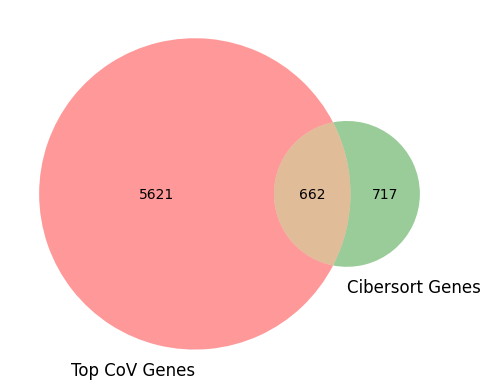

In [14]:
venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [15]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

In [16]:
np.any(np.isin(union_genes, ["PRDM1"]))

True

### normalize

In [17]:
X_full = X_full.loc[:,union_genes]

# rescale sc_ref and bulks
median_sc_ref = np.median(np.quantile(X_full.iloc[sc_idx], axis=1, q=0.9))
median_bulk = np.median(np.quantile(X_full.iloc[bulk_idx], axis=1, q=0.9))

ratio_medians = median_bulk/median_sc_ref

X_full.iloc[sc_idx] = X_full.iloc[sc_idx]*ratio_medians


In [18]:

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


### plot data

In [19]:
idx_tmp = np.random.choice(range(X_full.shape[0]), 5000, replace=True)
idx_tmp

array([11133, 13631,  5590, ...,  2874,  8954,  5433])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 2.322s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.173085
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.551292
[t-SNE] KL divergence after 500 iterations: 1.022913
(5000, 2)
(5000, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/2600809812.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


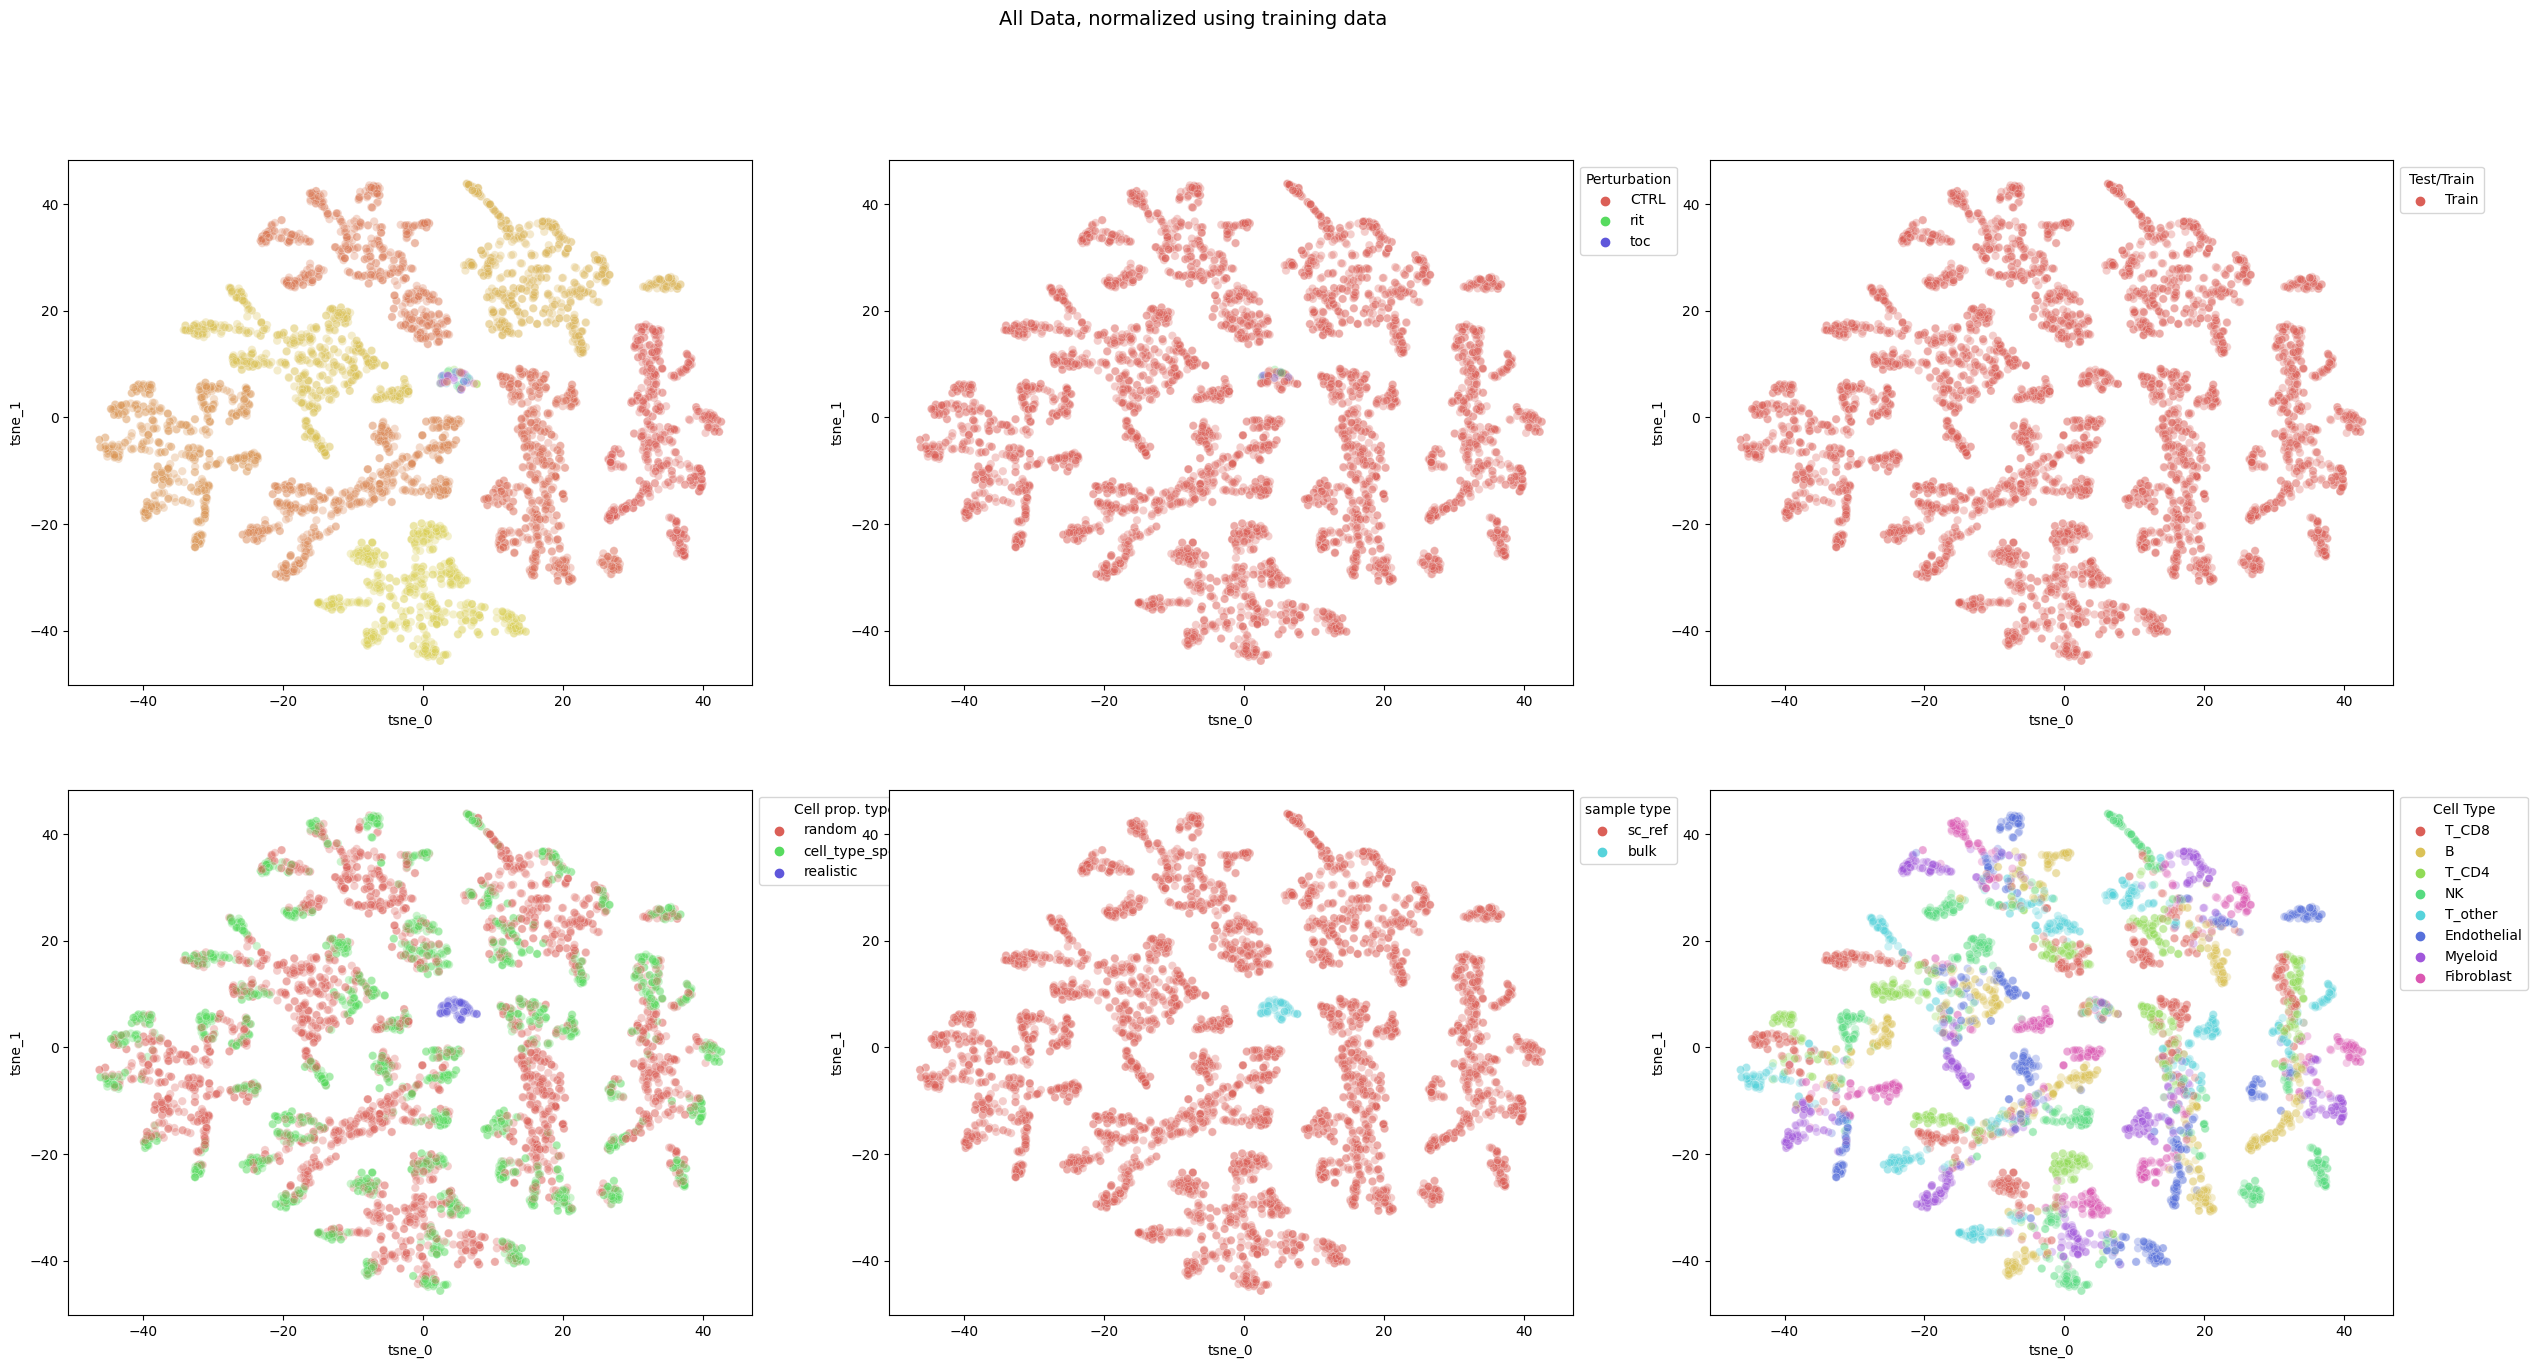

In [20]:
## plot samples

idx_tmp = np.random.choice(range(X_full.shape[0]), 5000, replace=True)

plot_df = vp.get_tsne_for_plotting(X_full[idx_tmp,])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

# this is a vector that represents the cell-type with 
# the highest proportion 
Y_temp = np.copy(Y_full.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]


vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"", legend_title="Sample ID")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].stim.to_numpy(), axs[0,1], title=f"", legend_title="Perturbation")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"", legend_title="Test/Train")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].cell_prop_type.to_numpy(), axs[1,0], title=f"", legend_title="Cell prop. type")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].samp_type.to_numpy(), axs[1,1], title=f"", legend_title="sample type")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"", legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


(184, 2)
(184, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/2821073111.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


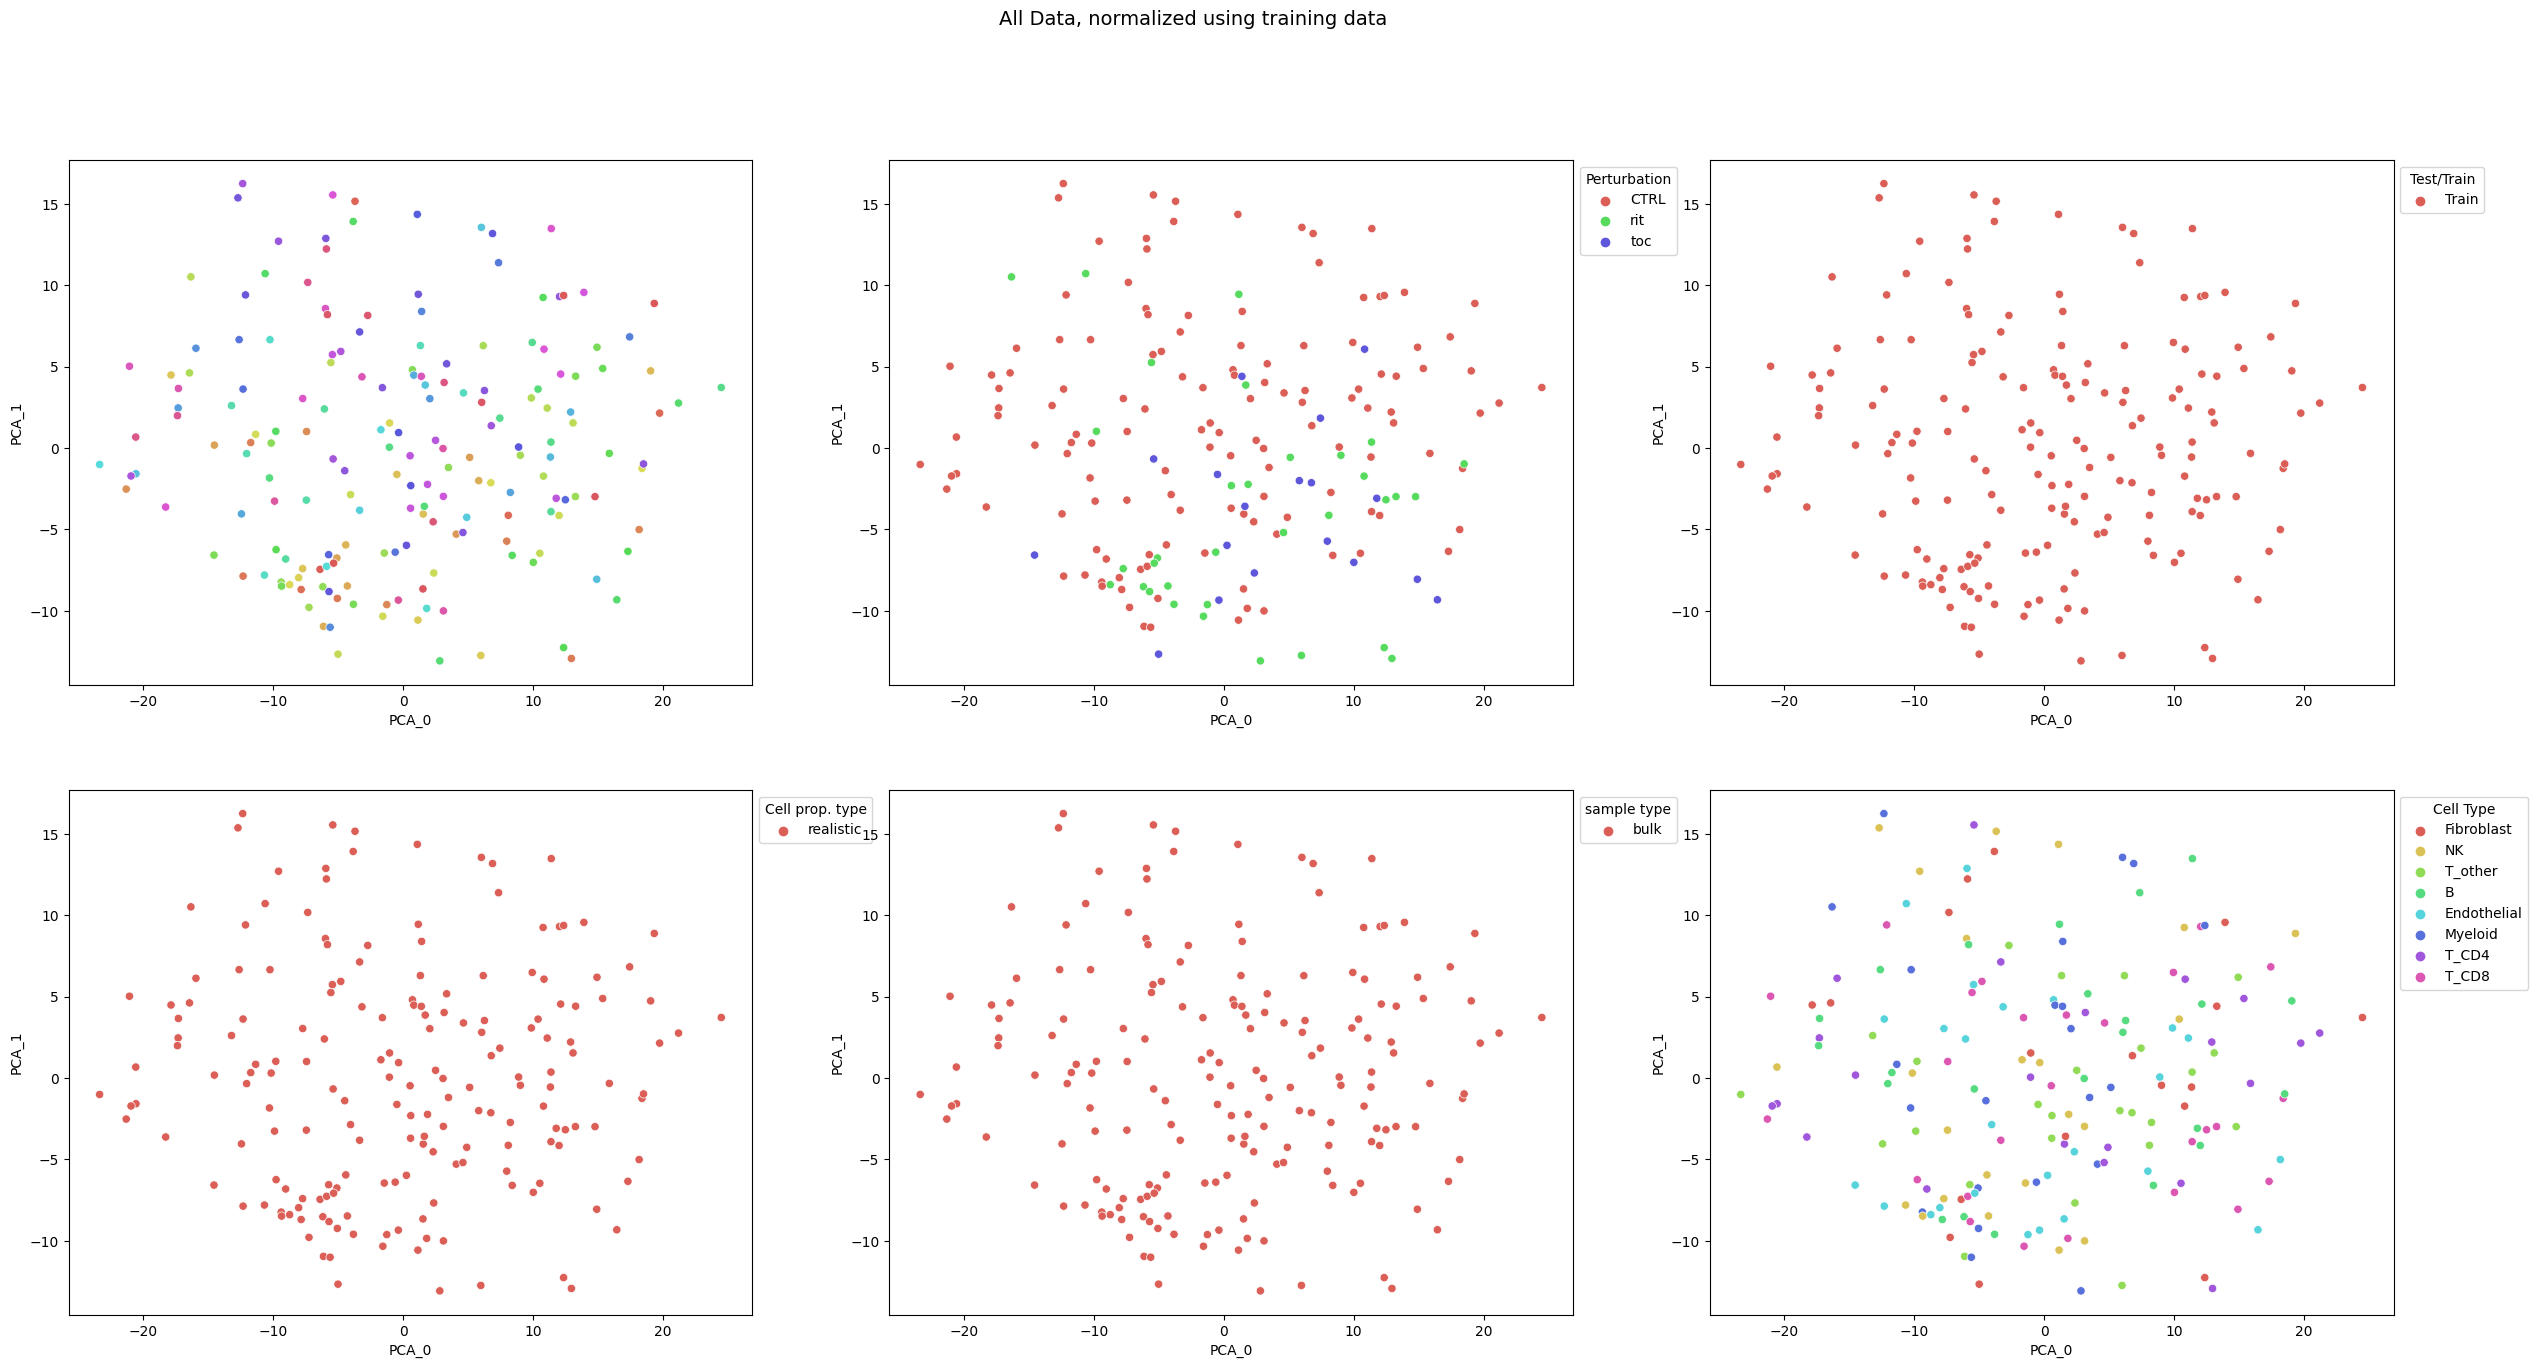

In [21]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"", alpha=1, legend_title="Sample ID")
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"", alpha=1, legend_title="Perturbation")
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"", alpha=1, legend_title="Test/Train")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"", alpha=1, legend_title="Cell prop. type")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"", alpha=1, legend_title="sample type")
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"", alpha=1, legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 184 samples in 0.001s...
[t-SNE] Computed neighbors for 184 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 184 / 184
[t-SNE] Mean sigma: 6.089274
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.562107
[t-SNE] KL divergence after 500 iterations: 0.601591
(184, 2)
(184, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/2955274557.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


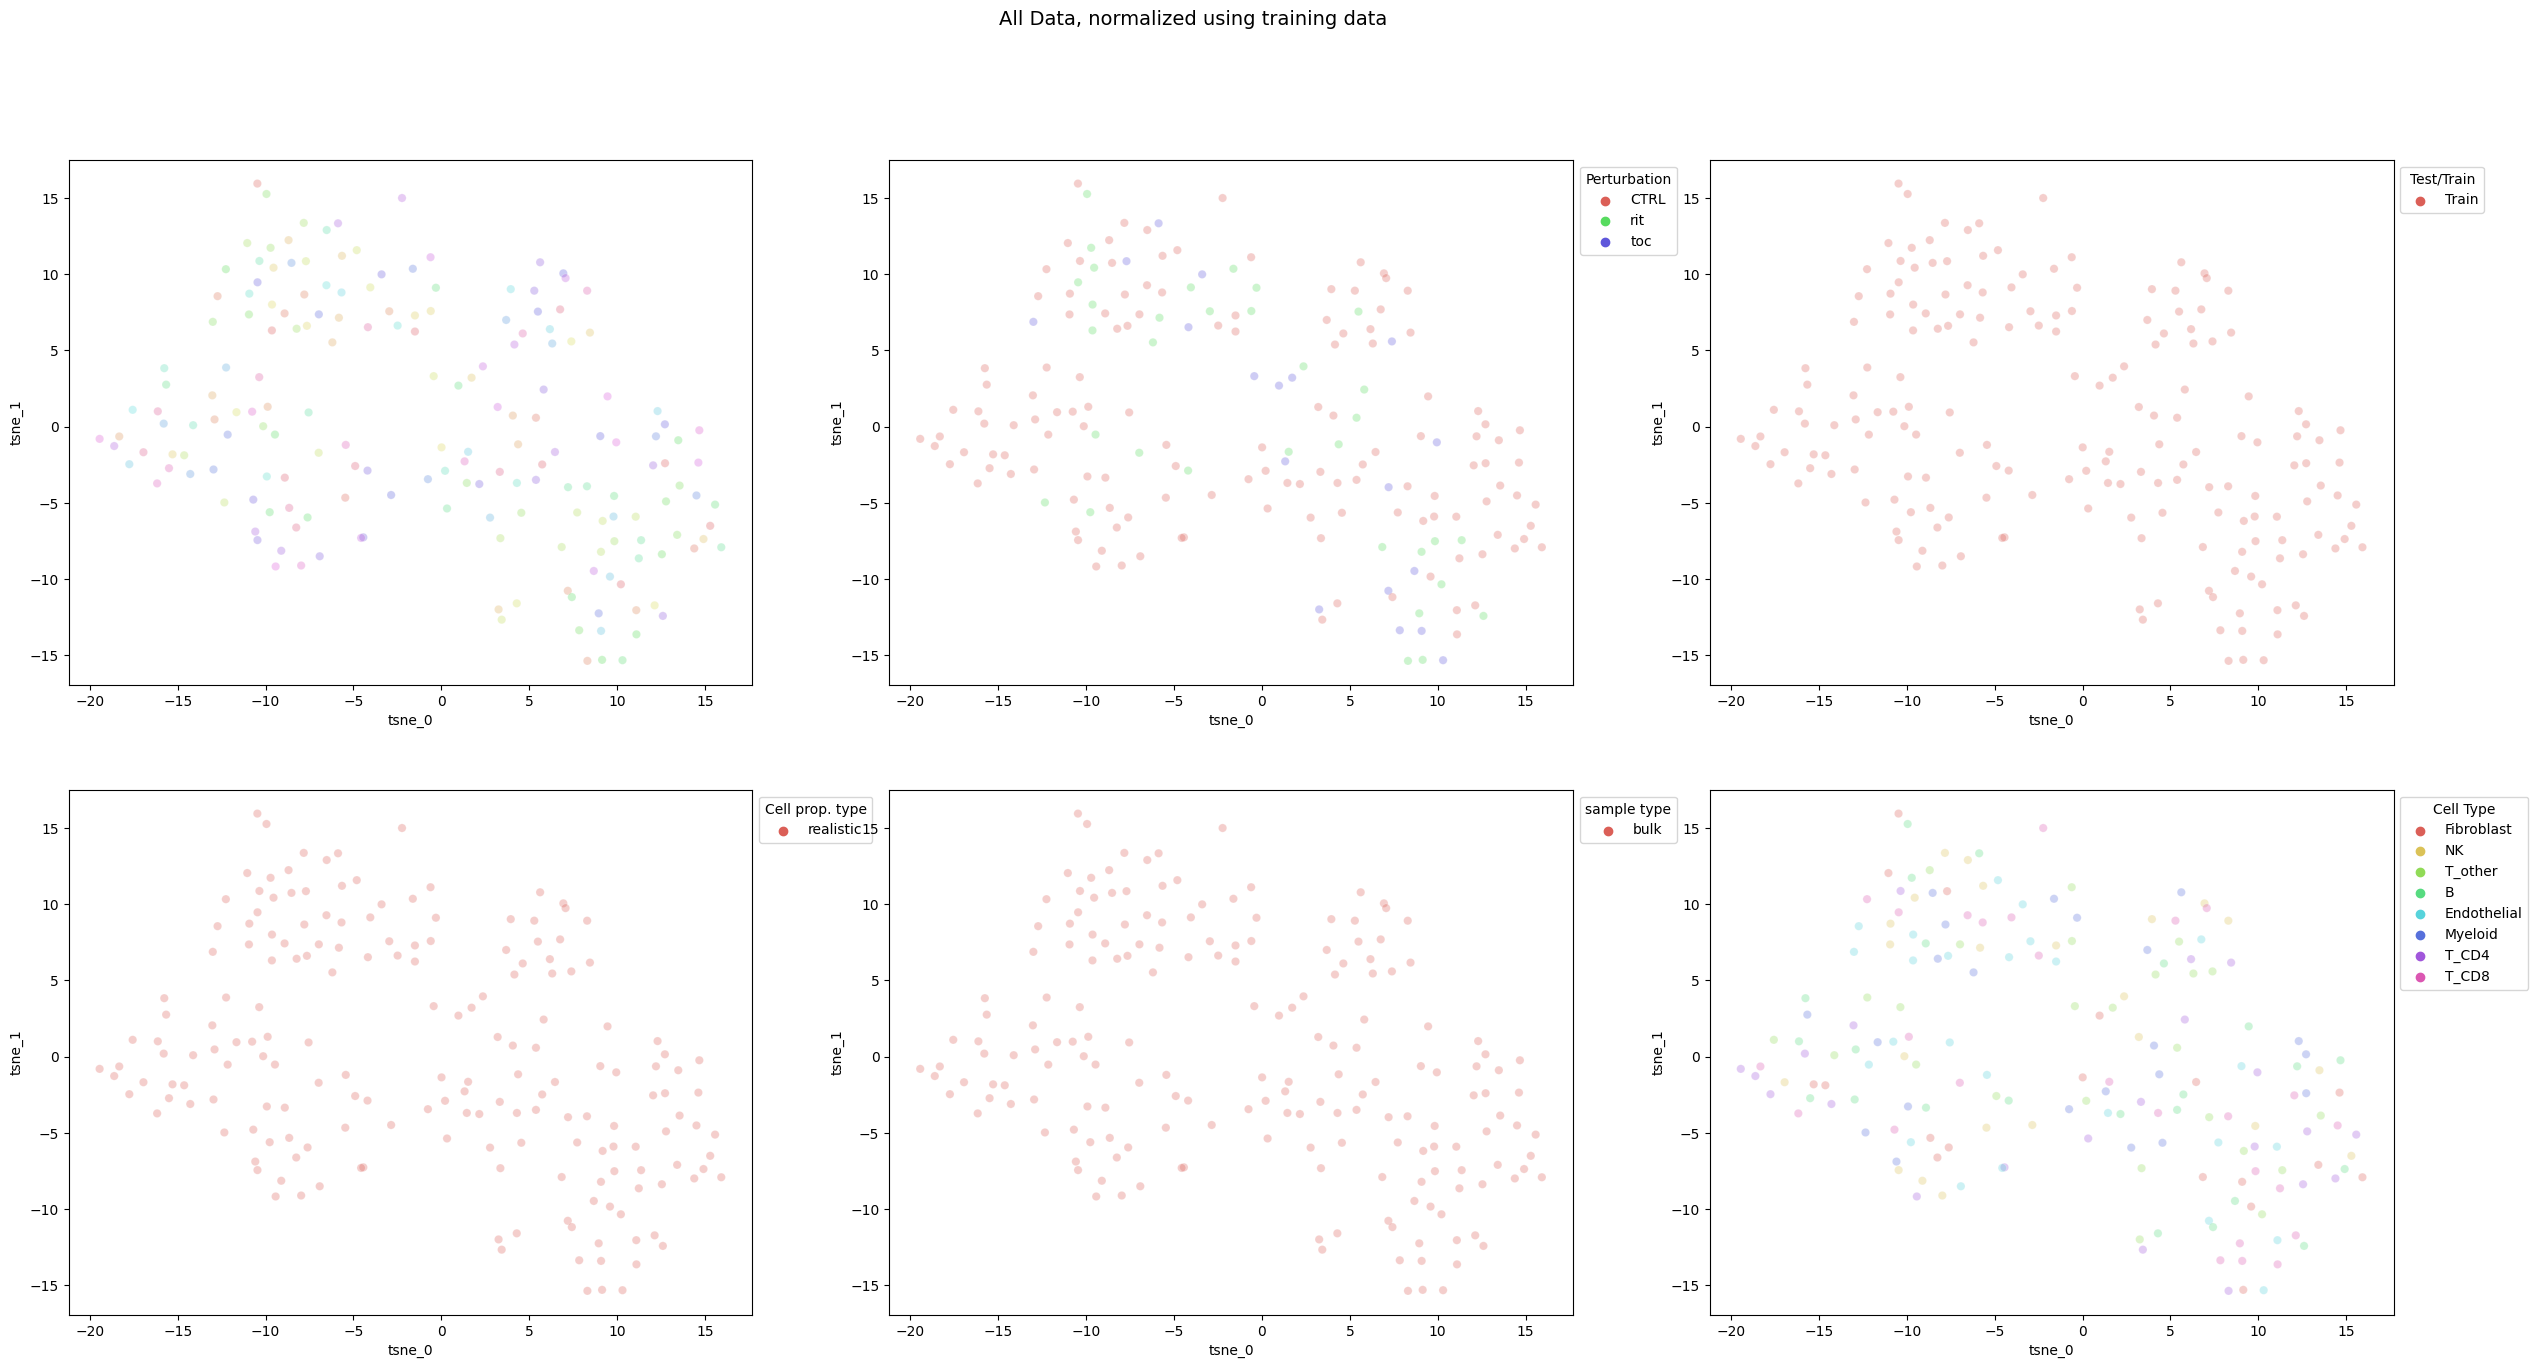

In [22]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_tsne_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], alpha=1, title=f"", legend_title="Sample ID")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], alpha=1, title=f"", legend_title="Perturbation")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], alpha=1, title=f"", legend_title="Test/Train")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], alpha=1, title=f"", legend_title="Cell prop. type")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], alpha=1, title=f"", legend_title="sample type")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"", alpha=1, legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Read in Trained Models**

In [23]:

res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/rittoc_model1_{res_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/rittoc_model1_{res_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/rittoc_model1_{res_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/rittoc_model1_{res_id}_classifier")


res2_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/rittoc_model2_{res_id}_encoder_unlab")
res2_enc_lab = tf.keras.models.load_model(f"{res_data_path}/rittoc_model2_{res_id}_encoder_lab")
res2_dec = tf.keras.models.load_model(f"{res_data_path}/rittoc_model2_{res_id}_decoder")
res2_classifier = tf.keras.models.load_model(f"{res_data_path}/rittoc_model2_{res_id}_classifier")


res3_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/rittoc_model3_{res_id}_encoder_unlab")
res3_enc_lab = tf.keras.models.load_model(f"{res_data_path}/rittoc_model3_{res_id}_encoder_lab")
res3_dec = tf.keras.models.load_model(f"{res_data_path}/rittoc_model3_{res_id}_decoder")
res3_classifier = tf.keras.models.load_model(f"{res_data_path}/rittoc_model3_{res_id}_classifier")



2024-04-02 10:33:50.253656: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-04-02 10:33:50.313146: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_7' id:270 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_7}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_11, Identity_7)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-02 10:33:50.922474: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_44' id:679 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_44}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_20, Identity_44)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-02 10:33:51.164668: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_48' id:833 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_48}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_24, Identity_48)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-02 10:33:51.355601: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_52' id:918 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_52}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_26, Identity_52)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an

2024-04-02 10:33:51.940175: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_76' id:1221 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_76}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_36, Identity_76)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-02 10:33:52.844517: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_91' id:1586 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_91}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_43, Identity_91)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-02 10:33:53.178673: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_108' id:1766 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_108}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_54, Identity_108)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-02 10:33:53.482766: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_110' id:1847 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_110}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_55, Identity_110)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-02 10:33:54.160167: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_127' id:2136 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_127}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_61, Identity_127)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-02 10:33:54.963644: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_142' id:2501 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_142}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_71, Identity_142)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-02 10:33:55.450113: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_166' id:2695 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_166}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_83, Identity_166)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-04-02 10:33:55.864333: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_171' id:2782 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_171}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_85, Identity_171)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


## Do latent space projectsions

### drug perturbation

In [24]:
def calc_buddi_perturbation_sampIDs(meta_df, X_full, Y_full, scaler, 
                            encoder_unlab, decoder, batch_size, 
                            genes_ordered, top_lim=100, use_buddi4=True):
 
    """
    Plot general perturbation response for BuDDI. 
    We couple all latents spaces except for the perturbation effect during sampling.

    meta_df: pandas dataframe of the metadata associated with X_full and Y_full
    X_full: Normalized gene expression, assumed in the same order as expected by BuDDI
    Y_full: Cell type proportions
    scaler: the scaler used during normalization
    encoder_unlab: BuDDI unsupervised encoder
    decoder: BuDDI decoder
    batch_size: batch size
    genes_ordered: the gene IDs matching the genes in X_full, which should also be in the same order as BuDDI
    top_lim: how many genes to report as top perturbed
    use_buddi4: Whether BuDDI has 3 or 4 latent spaces

    """

    # get the training data
    # so we can use it to get the latent codes

    # get the points we are interested in
    # we will use their codes and only change the perturbation codes
    subset_idx = np.logical_and(meta_df.isTraining == "Train", meta_df.cell_prop_type == "cell_type_specific")
    subset_idx = np.logical_and(subset_idx, meta_df.stim == "CTRL")
    subset_idx = np.where(subset_idx)[0] 
    subset_idx = np.random.choice(subset_idx, 8000, replace=True)

    temp_meta_df = meta_df.iloc[subset_idx]

    X_temp = np.copy(X_full)
    X_unpert = X_temp[subset_idx,]

    Y_temp = np.copy(Y_full)
    Y_temp = Y_temp[subset_idx]


    #####
    # get unperturbed latent codes
    #####
    if use_buddi4:
        _, _, _, _, _, _, z_unpert, _, _, _, _, _  = encoder_unlab.predict(X_unpert, batch_size=batch_size)
    else:
        _, _, _, _, _, _, z_unpert, _, _  = encoder_unlab.predict(X_unpert, batch_size=batch_size)

    #####
    # get perturbation latent codes
    #####

    # get the index to get the perturbation latent codes
    pert_code_idx = np.logical_and(meta_df.isTraining == "Train", meta_df.stim == "STIM")
    pert_code_idx = np.where(pert_code_idx)[0] 
    pert_code_idx = np.random.choice(pert_code_idx, len(subset_idx), replace=True)
    if use_buddi4:
        z_slack, _, _, z_samples, _, _, z_pert, _, _, z_bulk, _, _  = encoder_unlab.predict(X_temp[pert_code_idx,], batch_size=batch_size)
    else:
        z_slack, _, _, z_samples, _, _, z_bulk, _, _  = encoder_unlab.predict(X_temp[pert_code_idx,], batch_size=batch_size)


    # make the metadata table 
    temp_meta_df = meta_df.iloc[subset_idx]
    temp_meta_df.isTraining = "Test"
    temp_meta_df.cell_prop_type = "cell_type_specific"
    temp_meta_df.sample_id = meta_df.sample_id.iloc[pert_code_idx].to_list()


    ######
    # now put it all together
    ######

    # now concatenate together and add the stim codes to the latent
    if use_buddi4:
        z_concat_perturb = np.hstack([z_slack, Y_temp, z_samples, z_pert, z_bulk])
    else:
        z_concat_perturb = np.hstack([z_slack, Y_temp, z_samples, z_bulk])
    decoded_0_1 = decoder.predict(z_concat_perturb, batch_size=batch_size)
    decoded_0_1 = scaler.inverse_transform(decoded_0_1)

    # now concatenate together and add the stim codes to the latent
    if use_buddi4:
        z_concat_unperturb = np.hstack([z_slack, Y_temp, z_samples, z_unpert, z_bulk])
    else:
        z_concat_unperturb = np.hstack([z_slack, Y_temp, z_samples, z_bulk])

    decoded_0_0 = decoder.predict(z_concat_unperturb, batch_size=batch_size)
    decoded_0_0 = scaler.inverse_transform(decoded_0_0)

    ######
    # now get the differential genes
    ######


    top_genes = {}
    de_genes_all = None
    for curr_cell_type in Y_full.columns:


        # this is for the "projected" expression
        curr_idx = np.where(temp_meta_df.Y_max == curr_cell_type)[0]
        proj_ctrl = decoded_0_0[curr_idx]
        proj_stim = decoded_0_1[curr_idx]

        # take the median for nomalization

        proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
        proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
        proj_log2FC = np.abs(proj_stim-proj_ctrl)

        # make into DF
        proj_log2FC_df = pd.DataFrame(proj_log2FC, index=genes_ordered)

        intersect_proj = proj_log2FC_df.loc[genes_ordered][0]
        top_proj_genes = intersect_proj.index[np.argsort(np.abs(intersect_proj))].tolist()[::-1][0:top_lim]

        top_genes[curr_cell_type] = top_proj_genes



    return (temp_meta_df, decoded_0_0, decoded_0_1, top_genes)



In [25]:

toc_idx = np.where(meta_df.stim != "rit")[0]
meta_df_toc = meta_df.copy()
meta_df_toc.stim.iloc[np.where(meta_df_toc.stim != "CTRL")] = "STIM"

resToc_meta_df_res1, resToc_decoded_0_0_res1, resToc_decoded_0_1_res1, resToc_top_genes_res1 = calc_buddi_perturbation_sampIDs(meta_df_toc.iloc[toc_idx], X_full[toc_idx,:], Y_full.iloc[toc_idx], scaler, 
                                                                                                                                res1_enc_unlab, res1_dec, batch_size=500, 
                                                                                                                                genes_ordered=union_genes, 
                                                                                                                                top_lim=100, use_buddi4=True)


resToc_meta_df_res2, resToc_decoded_0_0_res2, resToc_decoded_0_1_res2, resToc_top_genes_res2 = calc_buddi_perturbation_sampIDs(meta_df_toc.iloc[toc_idx], X_full[toc_idx,:], Y_full.iloc[toc_idx], scaler, 
                                                                                                                                res2_enc_unlab, res2_dec, batch_size=500, 
                                                                                                                                genes_ordered=union_genes, 
                                                                                                                                top_lim=100, use_buddi4=True)



resToc_meta_df_res3, resToc_decoded_0_0_res3, resToc_decoded_0_1_res3, resToc_top_genes_res3 = calc_buddi_perturbation_sampIDs(meta_df_toc.iloc[toc_idx], X_full[toc_idx,:], Y_full.iloc[toc_idx], scaler, 
                                                                                                                                res3_enc_unlab, res3_dec, batch_size=500, 
                                                                                                                                genes_ordered=union_genes, 
                                                                                                                                top_lim=100, use_buddi4=True)


rit_idx = np.where(meta_df.stim != "toc")[0]
meta_df_rit = meta_df.copy()
meta_df_rit.stim.iloc[np.where(meta_df_rit.stim != "CTRL")] = "STIM"

resRit_meta_df, resRit_decoded_0_0, resRit_decoded_0_1, resRit_top_genes = calc_buddi_perturbation_sampIDs(meta_df_rit.iloc[rit_idx], X_full[rit_idx,:], Y_full.iloc[rit_idx], scaler, 
                                                                            res1_enc_unlab, res1_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/308850687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df_toc.stim.iloc[np.where(meta_df_toc.stim != "CTRL")] = "STIM"
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-02 10:33:57.311191: W tensorflow/c/c_api.cc:304] Operation '{name:'tf_op_layer_z_samp_slack/add/z_samp_slack/add' id:375 op device:{requested: '', assigned: ''} def:{{{node tf_op_layer_z_samp_slack/add/z_samp_slack/add}} = AddV2[T=DT_FLOAT, _cloned=true, _has_manual_control_dependencies

### get the average cell type proportions expected

In [26]:
resRit_meta_df

,sample_id,stim,isTraining,cell_prop_type,samp_type,response,paired,treatment_x,subject_id,pipeline_date,...,tissue_type,krenn_lining,krenn_inflammation,single_cell_tech,cell_count_to_10x,mRNA_run,protein_run,atac_run,qc,Y_max
12061,R4RAPAT00137,CTRL,Test,cell_type_specific,sc_ref,Non.Responder,unpaired,CTRL,300-0504,9/17/19,...,Biopsy,0.67,1.67,CITEseq,11500,BRI-515,BRI-516,NaN,Pass,Endothelial
10394,R4RAPAT00126,CTRL,Test,cell_type_specific,sc_ref,Non.Responder,unpaired,CTRL,300-0531,8/26/19,...,Biopsy,1.33,1.33,CITEseq,"4,000",BRI-475,BRI-476,NaN,Pass,Fibroblast
10799,R4RAPAT00039,CTRL,Test,cell_type_specific,sc_ref,Non.Responder,unpaired,CTRL,300-0531,8/26/19,...,Biopsy,1.33,1.33,CITEseq,"4,000",BRI-475,BRI-476,NaN,Pass,T_CD8
1495,R4RAPAT00137,CTRL,Test,cell_type_specific,sc_ref,Non.Responder,unpaired,CTRL,300-0501,8/12/19,...,Biopsy,1.33,2.33,CITEseq,"12,400",BRI-421,BRI-422,NaN,Pass,Myeloid
3581,R4RAPAT00138,CTRL,Test,cell_type_specific,sc_ref,Non.Responder,unpaired,CTRL,300-0223,8/15/19,...,Biopsy,1.33,3.00,CITEseq,"12,000",BRI-436,BRI-437,NaN,Pass,T_CD8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3149,R4RAPAT00097,CTRL,Test,cell_type_specific,sc_ref,Non.Responder,unpaired,CTRL,300-0223,8/15/19,...,Biopsy,1.33,3.00,CITEseq,"12,000",BRI-436,BRI-437,NaN,Pass,Fibroblast
3354,R4RAPAT00091,CTRL,Test,cell_type_specific,sc_ref,Non.Responder,unpaired,CTRL,300-0223,8/15/19,...,Biopsy,1.33,3.00,CITEseq,"12,000",BRI-436,BRI-437,NaN,Pass,T_other
10500,R4RAPAT00039,CTRL,Test,cell_type_specific,sc_ref,Non.Responder,unpaired,CTRL,300-0531,8/26/19,...,Biopsy,1.33,1.33,CITEseq,"4,000",BRI-475,BRI-476,NaN,Pass,T_other
14223,R4RAPAT00053,CTRL,Test,cell_type_specific,sc_ref,Non.Responder,unpaired,CTRL,300-0507,9/30/19,...,Biopsy,1.00,3.00,CITEseq,17000,BRI-542,BRI-543,NaN,Pass,T_CD4


In [27]:
# now lets compare the b cell proportions before and after
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.samp_type == "bulk"))[0]
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = res2_classifier.predict(X_tmp, batch_size=500)

# compare before and after
temp_meta_df = meta_df.iloc[idx_tmp]

# prop of Toc
idx_toc = np.where(temp_meta_df.stim == "toc")[0]
prop_outputs_toc = prop_outputs[idx_toc]
prop_outputs_toc = np.median(prop_outputs_toc, axis=0)
prop_outputs_toc = prop_outputs_toc / prop_outputs_toc.sum()


# prop of Rit
idx_rit = np.where(temp_meta_df.stim == "rit")[0]
prop_outputs_rit = prop_outputs[idx_rit]
prop_outputs_rit = np.median(prop_outputs_rit, axis=0)
prop_outputs_rit = prop_outputs_rit / prop_outputs_rit.sum()



# prop of ctrl
idx_ctrl = np.where(temp_meta_df.stim == "CTRL")[0]
prop_outputs_ctrl = prop_outputs[idx_ctrl]
prop_outputs_ctrl = np.median(prop_outputs_ctrl, axis=0)
prop_outputs_ctrl = prop_outputs_ctrl / prop_outputs_ctrl.sum()





/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-02 10:34:48.124323: W tensorflow/c/c_api.cc:304] Operation '{name:'cls_out_1/Softmax' id:1872 op device:{requested: '', assigned: ''} def:{{{node cls_out_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](cls_out_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [28]:
prop_outputs_toc

array([5.07364534e-02, 2.92749137e-01, 6.69763610e-02, 3.99092725e-03,
       3.99337560e-01, 5.45655973e-02, 1.31530479e-01, 1.13480026e-04],
      dtype=float32)

In [29]:
prop_outputs_rit

array([1.1675129e-01, 7.9090901e-02, 1.8930793e-01, 2.7194992e-02,
       4.7170353e-01, 4.8357043e-02, 6.7357764e-02, 2.3657571e-04],
      dtype=float32)

In [30]:
prop_outputs_ctrl

array([0.03334483, 0.14984083, 0.01486839, 0.10104112, 0.5431429 ,
       0.05444442, 0.06186756, 0.04144988], dtype=float32)

In [31]:
# make anndata for BuDDI
def make_anndata_buddi(res1_decoded_0_0, res1_decoded_0_1, res1_meta_df, union_genes):

    adata_counts = np.append(res1_decoded_0_0, res1_decoded_0_1, axis=0)
    adata_df = pd.DataFrame(adata_counts)
    adata_df.columns = union_genes

    ad_union_genes = pd.DataFrame(union_genes)
    ad_union_genes.index = union_genes

    res1_meta_df_stim = res1_meta_df.copy()
    res1_meta_df_stim.stim = "STIM"
    res1_meta_df_obs = res1_meta_df.append(res1_meta_df_stim)

    adata = ad.AnnData(adata_df, obs=res1_meta_df_obs, var=ad_union_genes)

    return (adata, adata_df)


# make anndata for BayesPrism
def make_anndata_bayesprism(bp_bulk_Z_path, bp_bulk_Zmeta_path):
    
    ## get with bayesprism
    bp_bulk = pd.read_csv(bp_bulk_Z_path, delimiter="\t")
    bp_bulk_meta = pd.read_csv(bp_bulk_Zmeta_path, delimiter="\t")



    def get_stim_id(in_str):
        out_str = "STIM"
        if in_str == "week0":
            out_str = "CTRL"
            
        return(out_str)

    bp_bulk_meta['stim'] = [get_stim_id(str(x)) for x in bp_bulk_meta["time"].tolist()]



    bp_adata_df = pd.DataFrame(bp_bulk)
    bp_union_genes = bp_adata_df.columns
    bp_adata_df = bp_adata_df[bp_union_genes]

    ad_bp_union_genes = pd.DataFrame(bp_union_genes)
    ad_bp_union_genes.index = bp_union_genes


    # format meta data
    bp_bulk_meta["Y_max"] = bp_bulk_meta.cell_type


    # make anndata
    bp_adata = ad.AnnData(bp_adata_df, obs=bp_bulk_meta, var=ad_bp_union_genes)

    return (bp_adata, bp_adata_df)



## Format BuDDI

In [32]:
adata_resToc_res1, adata_resToc_df_res1 = make_anndata_buddi(resToc_decoded_0_0_res1, resToc_decoded_0_1_res1, resToc_meta_df_res1, union_genes)
adata_resToc_res2, adata_resToc_df_res2 = make_anndata_buddi(resToc_decoded_0_0_res2, resToc_decoded_0_1_res2, resToc_meta_df_res2, union_genes)
adata_resToc_res3, adata_resToc_df_res3 = make_anndata_buddi(resToc_decoded_0_0_res3, resToc_decoded_0_1_res3, resToc_meta_df_res3, union_genes)


adata_resRit, adata_resRit_df = make_anndata_buddi(resRit_decoded_0_0, resRit_decoded_0_1, resRit_meta_df, union_genes)




/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/3037078427.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res1_meta_df_obs = res1_meta_df.append(res1_meta_df_stim)
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/3037078427.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [33]:
adata_resRit.obs.cell_prop_type.value_counts()

cell_type_specific    16000
Name: cell_prop_type, dtype: int64

In [34]:
adata_resRit.obs.Y_max.value_counts()

B              2082
T_other        2054
Endothelial    2030
Fibroblast     2012
T_CD4          2004
NK             1996
Myeloid        1932
T_CD8          1890
Name: Y_max, dtype: int64

## Get pathway enrichments

In [35]:

def format_de_bulk(de_bulk, union_genes):
    de_bulk.index = [x.upper() for x in de_bulk.index] 
    de_bulk = de_bulk.iloc[np.where(de_bulk.padj < 1)[0]]
    intersect_bulk = np.intersect1d(de_bulk.index.to_list(), union_genes)

    bulk_sig_df = pd.DataFrame(union_genes, index=union_genes)
    bulk_sig_df["padj"] = 1
    padj_val = de_bulk.padj[intersect_bulk]
    bulk_sig_df.padj.loc[intersect_bulk] = padj_val

    bulk_sig_df["log10padj"] = -1*np.log10(bulk_sig_df.padj)

    bulk_sig_df["log2FC"] = 1
    fc_val = de_bulk.log2FoldChange[intersect_bulk]
    bulk_sig_df.log2FC.loc[intersect_bulk] = fc_val

    return bulk_sig_df

In [36]:
## read in the DE from bulk

de_bulk = pickle.load(open( de_bulk_path, "rb" ))

de_bulk_toc = de_bulk.iloc[np.where(de_bulk.drug == "toc")]
de_bulk_toc = format_de_bulk(de_bulk_toc, union_genes)
de_bulk_toc = de_bulk_toc.sort_values(by="log2FC", ascending=False)
de_bulk_toc_genes = de_bulk_toc.index.to_list()


de_bulk_toc = de_bulk_toc.iloc[np.where(de_bulk_toc.padj < 0.01)[0]]


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/1465673280.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.padj.loc[intersect_bulk] = padj_val
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/1465673280.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_sig_df.log2FC.loc[intersect_bulk] = fc_val


In [37]:


def make_realistic_pseudobulk(num_pseudos, prop_expected, cell_order, adata, adata_df, drug_str, sample_interest):
    # we assume there is at least 1500 observations of each cell type
    # also each adata object only contains cell type specific responses
    # we are going to estimate what the "bulk" could really look like using the cell proportions

    # make realistic pseudobulk

    pseudobulk_df = np.empty([num_pseudos,7000])
    pseudobulk_idx = 0



    for curr_pseudo in range(num_pseudos):
        curr_idx = 0
        keep_idx = np.array([])

        for curr_idx in range(len(prop_expected)):

            curr_cell_idx = cell_order[curr_idx]
            curr_cell_idx = np.logical_and(adata.obs.Y_max == curr_cell_idx, adata.obs.stim == drug_str)
            curr_cell_idx = np.logical_and(curr_cell_idx, adata.obs.sample_id == sample_interest)
            
            curr_keep_idx = np.random.choice(np.where(curr_cell_idx)[0], 
                                                (np.rint(100*prop_expected[curr_idx]).astype(np.int32)+1))
            keep_idx = np.append(keep_idx, curr_keep_idx)


        X_pseudo = adata_df.iloc[keep_idx.astype(np.int32)]
        X_pseudo = X_pseudo.sum(axis=0)
        pseudobulk_df[pseudobulk_idx] = X_pseudo

        pseudobulk_idx = pseudobulk_idx + 1

    pseudobulk_df = pd.DataFrame(pseudobulk_df)
    pseudobulk_df.columns = adata_df.columns

    return(pseudobulk_df)



In [38]:

def compare_pseudos(num_pseudos, prop_expected_stim, prop_expected_ctrl, adata, adata_df, cell_order):
    pseudos_real_stim_all = None
    pseudos_real_ctrl_all = None

    for curr_samp in np.unique(adata.obs.sample_id):

        # get sample specific pseudobulk
        pseudos_real_stim = make_realistic_pseudobulk(num_pseudos, prop_expected_stim, cell_order, adata, adata_df, drug_str="STIM", sample_interest=curr_samp)
        pseudos_real_ctrl = make_realistic_pseudobulk(num_pseudos, prop_expected_ctrl, cell_order, adata, adata_df, drug_str="CTRL", sample_interest=curr_samp)


        # append
        if pseudos_real_stim_all is None:
            pseudos_real_stim_all = pseudos_real_stim
        else:
            pseudos_real_stim_all = pd.concat([pseudos_real_stim_all, pseudos_real_stim])
        
        if pseudos_real_ctrl_all is None:
            pseudos_real_ctrl_all = pseudos_real_ctrl
        else:
            pseudos_real_ctrl_all = pd.concat([pseudos_real_ctrl_all, pseudos_real_ctrl])

    proj_ctrl = np.median(rankdata(pseudos_real_ctrl_all, axis=1), axis=0)
    proj_stim = np.median(rankdata(pseudos_real_stim_all, axis=1), axis=0)
    proj_log2FC = abs(proj_stim-proj_ctrl)

    proj_log2FC_df = pd.DataFrame(proj_log2FC, index=union_genes)
    proj_log2FC_df["orig"] = proj_stim-proj_ctrl

    proj_log2FC_df = proj_log2FC_df.sort_values(by=['orig'], ascending=True)

    return proj_log2FC_df

        

In [58]:
top_genes = 500

toc_terms_paper = ["GOBP_INTERLEUKIN_6_PRODUCTION",
                    "GOBP_NEGATIVE_REGULATION_OF_CYTOKINE_PRODUCTION",
                    "GOBP_CYTOKINE_MEDIATED_SIGNALING_PATHWAY",
                    "GOBP_RESPONSE_TO_CYTOKINE",
                    "GOBP_INFLAMMATORY_RESPONSE",
                    "GOBP_REGULATION_OF_INTERLEUKIN_6_MEDIATED_SIGNALING_PATHWAY",
                    "GOBP_INTERLEUKIN_6_MEDIATED_SIGNALING_PATHWAY",
                    "GOBP_RESPONSE_TO_INTERLEUKIN_6"]


rit_terms_paper = ["GOBP_REGULATION_OF_HUMORAL_IMMUNE_RESPONSE", 
                   "GOBP_B_CELL_MEDIATED_IMMUNITY", 
                    "GOBP_COMPLEMENT_ACTIVATION", 
                    "GOBP_NEGATIVE_REGULATION_OF_B_CELL_ACTIVATION",
                    "GOBP_NEGATIVE_REGULATION_OF_B_CELL_MEDIATED_IMMUNITY", 
                    "GOBP_NEGATIVE_REGULATION_OF_B_CELL_PROLIFERATION",
                    "GOBP_NEGATIVE_REGULATION_OF_B_CELL_DIFFERENTIATION",
                    "GOBP_REGULATION_OF_B_CELL_APOPTOTIC_PROCESS"]


In [59]:
num_pseudos = 50


## even prop Toc
even_prop_toc_FC_df_res1 = compare_pseudos(num_pseudos, [0.125]*8, [0.125]*8, adata_resToc_res1, adata_resToc_df_res1, Y_full.columns.to_list())
even_prop_toc_FC_df_res2 = compare_pseudos(num_pseudos, [0.125]*8, [0.125]*8, adata_resToc_res2, adata_resToc_df_res2, Y_full.columns.to_list())
even_prop_toc_FC_df_res3 = compare_pseudos(num_pseudos, [0.125]*8, [0.125]*8, adata_resToc_res3, adata_resToc_df_res3, Y_full.columns.to_list())


### Tocilizumab pathway enrichments

In [41]:
Y_full.columns.to_list()

['NK',
 'B',
 'Endothelial',
 'Fibroblast',
 'Myeloid',
 'T_CD8',
 'T_CD4',
 'T_other']

In [60]:

even_prop_toc_enr_res1 = gp.enrich(gene_list=even_prop_toc_FC_df_res1.index.to_list()[1:top_genes], # or gene_list=glist
                                gene_sets=[gmt_path_go], # kegg is a dict object
                                background=union_genes, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                                outdir=None,
                                verbose=True)
even_prop_toc_enr_res2 = gp.enrich(gene_list=even_prop_toc_FC_df_res2.index.to_list()[1:top_genes], # or gene_list=glist
                                gene_sets=[gmt_path_go], # kegg is a dict object
                                background=union_genes, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                                outdir=None,
                                verbose=True)
even_prop_toc_enr_res3 = gp.enrich(gene_list=even_prop_toc_FC_df_res3.index.to_list()[1:top_genes], # or gene_list=glist
                                gene_sets=[gmt_path_go], # kegg is a dict object
                                background=union_genes, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                                outdir=None,
                                verbose=True)


even_prop_toc_enr_res1.res2d.iloc[np.where(np.isin(even_prop_toc_enr_res1.res2d.Term, toc_terms_paper))[0]]


2024-04-02 11:24:43,386 [INFO] User defined gene sets is given: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/synovium_analysis/../data/metadata/c5.go.bp.v2023.2.Hs.symbols.gmt
2024-04-02 11:24:43,487 [INFO] Run: c5.go.bp.v2023.2.Hs.symbols.gmt 
2024-04-02 11:24:43,798 [INFO] Done.
2024-04-02 11:24:43,805 [INFO] User defined gene sets is given: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/synovium_analysis/../data/metadata/c5.go.bp.v2023.2.Hs.symbols.gmt
2024-04-02 11:24:43,853 [INFO] Run: c5.go.bp.v2023.2.Hs.symbols.gmt 
2024-04-02 11:24:44,190 [INFO] Done.
2024-04-02 11:24:44,199 [INFO] User defined gene sets is given: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/synovium_analysis/../data/metadata/c5.go.bp.v2023.2.Hs.symbols.gmt
2024-04-02 11:24:44,249 [INFO] Run: c5.go.bp.v2023.2.Hs.symbols.gmt 
2024-04-02 11:24:44,579 [INFO] Done.


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
548,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_CYTOKINE_MEDIATED_SIGNALING_PATHWAY,57/265,1.143458e-14,3.798039e-12,3.922299,125.914184,CCDC3;CCR5;JAK3;IL33;LYN;CCL21;PTPRJ;CCL5;IFNG...
1056,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INFLAMMATORY_RESPONSE,86/466,2.256964e-17,1.339238e-14,3.365455,128.997641,IL33;AOC3;NFKB1;PTGFR;CCL5;IFNGR2;PYCARD;P2RX7...
1107,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_MEDIATED_SIGNALING_PATHWAY,2/15,2.905107e-01,5.797014e-01,2.415224,2.985494,PTPN2;JAK2
1108,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,16/93,7.838919e-04,1.187665e-02,2.828949,20.230491,LBP;MBP;HSPD1;LGALS9;MYD88;CD36;IL33;LILRB2;TL...
1615,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_NEGATIVE_REGULATION_OF_CYTOKINE_PRODUCTION,22/169,4.141982e-03,4.228151e-02,2.030012,11.137823,SLC11A1;JAK3;IL33;NFKB1;CR1;PYCARD;LILRB4;LRRC...
3302,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_REGULATION_OF_INTERLEUKIN_6_MEDIATED_SIGN...,1/3,1.990008e-01,4.915820e-01,7.822869,12.629603,PTPN2
3799,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_RESPONSE_TO_CYTOKINE,94/515,1.171634e-18,1.011823e-15,3.361884,138.805893,CCDC3;IL33;NFKB1;CCL5;IFNGR2;PYCARD;MYD88;MX2;...
3841,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_RESPONSE_TO_INTERLEUKIN_6,5/22,1.722654e-02,1.158632e-01,4.121306,16.737877,SBNO2;PTPN2;JAK2;NFKB1;CHI3L1


In [61]:

de_prop_toc_enr = gp.enrich(gene_list=de_bulk_toc.index.to_list()[1:top_genes], # or gene_list=glist
                                gene_sets=[gmt_path_go], # kegg is a dict object
                                background=union_genes, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                                outdir=None,
                                verbose=True)


de_prop_toc_enr.res2d.iloc[np.where(np.isin(de_prop_toc_enr.res2d.Term, toc_terms_paper))[0]]


2024-04-02 11:24:47,181 [INFO] User defined gene sets is given: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/synovium_analysis/../data/metadata/c5.go.bp.v2023.2.Hs.symbols.gmt
2024-04-02 11:24:47,248 [INFO] Run: c5.go.bp.v2023.2.Hs.symbols.gmt 
2024-04-02 11:24:47,535 [INFO] Done.


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
426,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_CYTOKINE_MEDIATED_SIGNALING_PATHWAY,36/265,1.161982e-04,3.415842e-03,2.152292,19.500221,IL21R;CCR5;IL2RA;CCL5;IL1B;PYCARD;IFITM2;IL6;B...
812,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INFLAMMATORY_RESPONSE,71/466,2.913832e-10,4.318541e-08,2.576328,56.566833,AIF1;GPSM3;C1QA;NKG7;SLC39A8;CCR5;SERPINA1;RPS...
846,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_MEDIATED_SIGNALING_PATHWAY,2/15,2.905107e-01,7.739367e-01,2.415224,2.985494,PTPN2;IL6
847,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,11/93,6.561646e-02,3.944053e-01,1.831810,4.989721,AIF1;IL6;LBP;HLA-B;CYBA;SELENOK;TYROBP;XBP1;IL...
1277,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_NEGATIVE_REGULATION_OF_CYTOKINE_PRODUCTION,15/169,2.232368e-01,7.270845e-01,1.314353,1.970902,FCGR2B;IL6;LBP;OAS1;HLA-F;NMI;BST2;CR1;GBP1;TY...
2682,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_REGULATION_OF_INTERLEUKIN_6_MEDIATED_SIGN...,1/3,1.990008e-01,6.846225e-01,7.822869,12.629603,PTPN2
3115,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_RESPONSE_TO_CYTOKINE,62/515,2.073454e-05,7.846037e-04,1.905339,20.546627,IL21R;AIF1;HAX1;CCR5;MT2A;IL2RA;CCL5;IL1B;PYCA...
3149,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_RESPONSE_TO_INTERLEUKIN_6,3/22,2.039558e-01,6.883775e-01,2.343455,3.725747,PTPN2;IL6;CHI3L1


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/1580751092.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


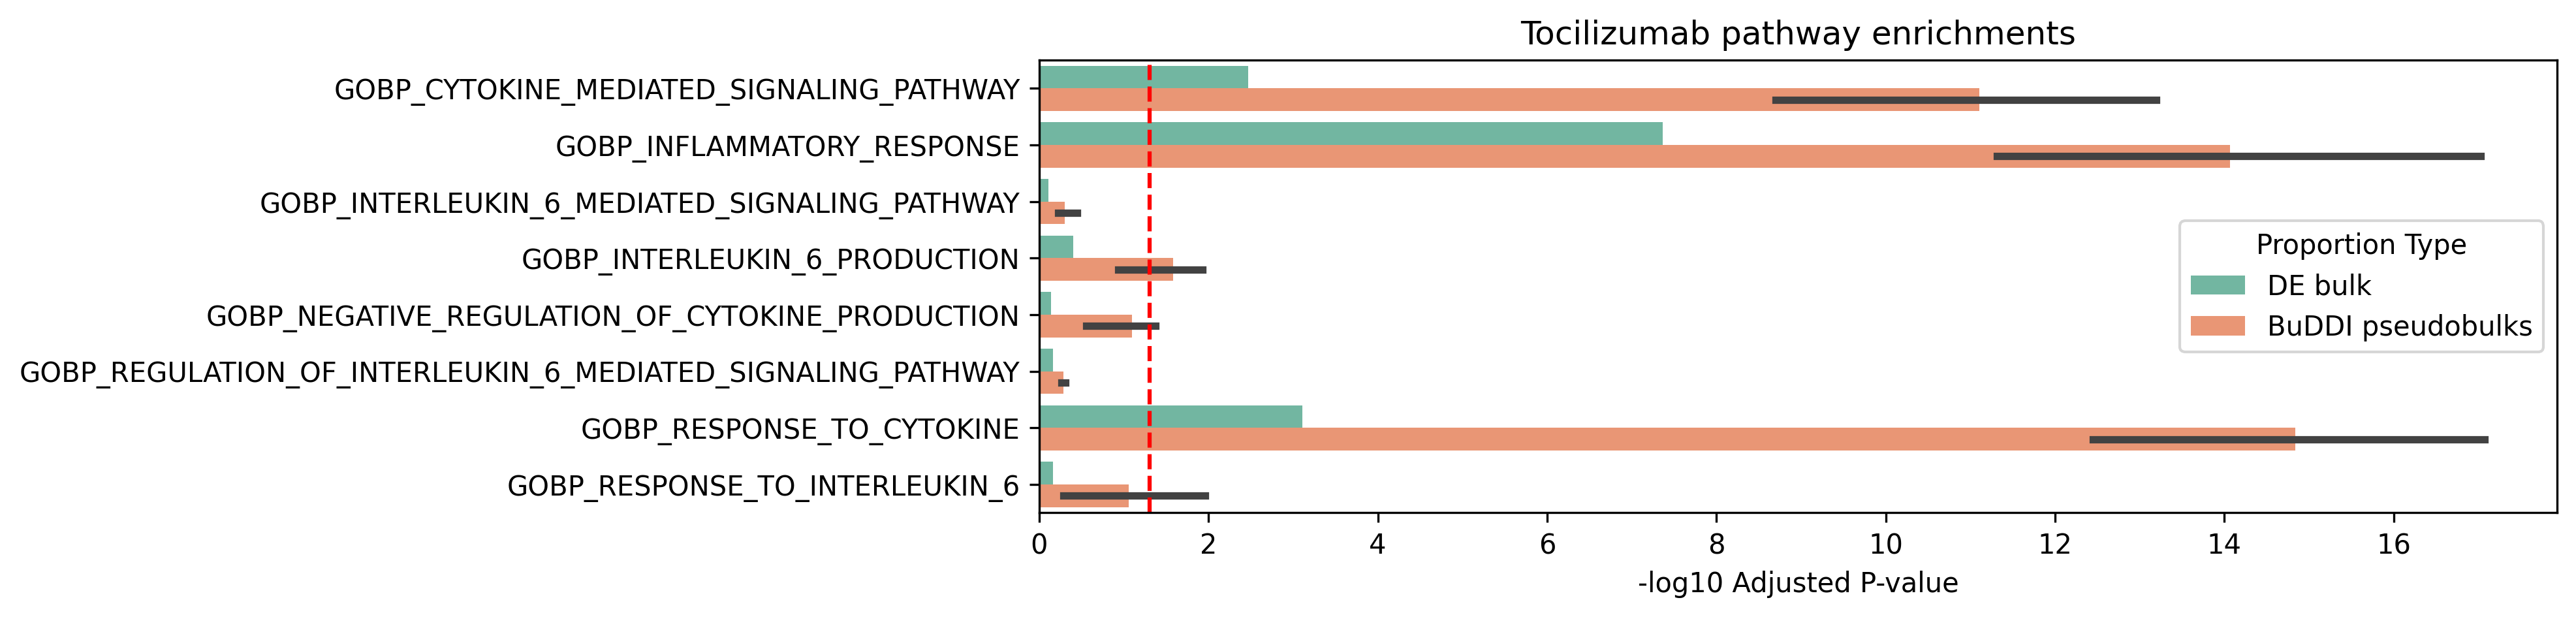

In [62]:
# now combine the enrichments and plot them

even_prop_df_res1 =  even_prop_toc_enr_res1.res2d.iloc[np.where(np.isin(even_prop_toc_enr_res1.res2d.Term, toc_terms_paper))[0]]
even_prop_df_res2 =  even_prop_toc_enr_res2.res2d.iloc[np.where(np.isin(even_prop_toc_enr_res2.res2d.Term, toc_terms_paper))[0]]
even_prop_df_res3 =  even_prop_toc_enr_res3.res2d.iloc[np.where(np.isin(even_prop_toc_enr_res3.res2d.Term, toc_terms_paper))[0]]
even_prop_df = pd.concat([even_prop_df_res1, even_prop_df_res2, even_prop_df_res3])


de_prop_df =  de_prop_toc_enr.res2d.iloc[np.where(np.isin(de_prop_toc_enr.res2d.Term, toc_terms_paper))[0]]
plot_enr_df = pd.concat([de_prop_df, even_prop_df])

plot_enr_df["Proportion Type"] = ["DE bulk"]*de_prop_df.shape[0] + ["BuDDI pseudobulks"]*even_prop_df.shape[0]

plot_enr_df["-log10 Adjusted P-value"] = -1 * np.log10(plot_enr_df["Adjusted P-value"])


# plot
fig, axs = plt.subplots(1, 1,  figsize=(10,3), dpi=300)

sns.barplot(data=plot_enr_df, 
        x="-log10 Adjusted P-value", y="Term", hue="Proportion Type",
        ax= axs)

axs.set(ylabel=None)
axs.axvline(x=-1*np.log10(0.05), color="red", linestyle="dashed")
axs.set_title(f"Tocilizumab pathway enrichments")

fig.show()


## Run cell type specific pathways

In [45]:


def get_celltype_spec_enr(cell_type_interest, cell_type_list, num_pseudos, top_genes, adata, adata_df, union_genes):

    ## cell type specific prop Toc
    cell_prop = np.array([0]*8)
    cell_prop[np.where(np.isin(cell_type_list, cell_type_interest))[0]] = 1

    T_CD8_toc_FC_df = compare_pseudos(num_pseudos, cell_prop, cell_prop, adata, adata_df, cell_type_list)

    T_CD8_toc_enr = gp.enrich(gene_list=T_CD8_toc_FC_df.index.to_list()[1:top_genes], # or gene_list=glist
                                    gene_sets=[gmt_path_go], # kegg is a dict object
                                    background=union_genes, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                                    outdir=None,
                                    verbose=True)

    return T_CD8_toc_enr



In [52]:
num_pseudos = 10
cell_type_list = Y_full.columns.to_list()
top_genes = 500


Fibroblast_toc_enr_res1 = get_celltype_spec_enr("Fibroblast", cell_type_list, num_pseudos, top_genes, adata_resToc_res1, adata_resToc_df_res1, union_genes)
Myeloid_toc_enr_res1 = get_celltype_spec_enr("Myeloid", cell_type_list, num_pseudos, top_genes, adata_resToc_res1, adata_resToc_df_res1, union_genes)
Endothelial_toc_enr_res1 = get_celltype_spec_enr("Endothelial", cell_type_list, num_pseudos, top_genes, adata_resToc_res1, adata_resToc_df_res1, union_genes)
T_CD8_toc_enr_res1 = get_celltype_spec_enr("T_CD8", cell_type_list, num_pseudos, top_genes, adata_resToc_res1, adata_resToc_df_res1, union_genes)
T_CD4_toc_enr_res1 = get_celltype_spec_enr("T_CD4", cell_type_list, num_pseudos, top_genes, adata_resToc_res1, adata_resToc_df_res1, union_genes)
T_other_toc_enr_res1 = get_celltype_spec_enr("T_other", cell_type_list, num_pseudos, top_genes, adata_resToc_res1, adata_resToc_df_res1, union_genes)
NK_toc_enr_res1 = get_celltype_spec_enr("NK", cell_type_list, num_pseudos, top_genes, adata_resToc_res1, adata_resToc_df_res1, union_genes)
B_toc_enr_res1 = get_celltype_spec_enr("B", cell_type_list, num_pseudos, top_genes, adata_resToc_res1, adata_resToc_df_res1, union_genes)


Fibroblast_toc_enr_res2 = get_celltype_spec_enr("Fibroblast", cell_type_list, num_pseudos, top_genes, adata_resToc_res2, adata_resToc_df_res2, union_genes)
Myeloid_toc_enr_res2 = get_celltype_spec_enr("Myeloid", cell_type_list, num_pseudos, top_genes, adata_resToc_res2, adata_resToc_df_res2, union_genes)
Endothelial_toc_enr_res2 = get_celltype_spec_enr("Endothelial", cell_type_list, num_pseudos, top_genes, adata_resToc_res2, adata_resToc_df_res2, union_genes)
T_CD8_toc_enr_res2 = get_celltype_spec_enr("T_CD8", cell_type_list, num_pseudos, top_genes, adata_resToc_res2, adata_resToc_df_res2, union_genes)
T_CD4_toc_enr_res2 = get_celltype_spec_enr("T_CD4", cell_type_list, num_pseudos, top_genes, adata_resToc_res2, adata_resToc_df_res2, union_genes)
T_other_toc_enr_res2 = get_celltype_spec_enr("T_other", cell_type_list, num_pseudos, top_genes, adata_resToc_res2, adata_resToc_df_res2, union_genes)
NK_toc_enr_res2 = get_celltype_spec_enr("NK", cell_type_list, num_pseudos, top_genes, adata_resToc_res2, adata_resToc_df_res2, union_genes)
B_toc_enr_res2 = get_celltype_spec_enr("B", cell_type_list, num_pseudos, top_genes, adata_resToc_res2, adata_resToc_df_res2, union_genes)


Fibroblast_toc_enr_res3 = get_celltype_spec_enr("Fibroblast", cell_type_list, num_pseudos, top_genes, adata_resToc_res3, adata_resToc_df_res3, union_genes)
Myeloid_toc_enr_res3 = get_celltype_spec_enr("Myeloid", cell_type_list, num_pseudos, top_genes, adata_resToc_res3, adata_resToc_df_res3, union_genes)
Endothelial_toc_enr_res3 = get_celltype_spec_enr("Endothelial", cell_type_list, num_pseudos, top_genes, adata_resToc_res3, adata_resToc_df_res3, union_genes)
T_CD8_toc_enr_res3 = get_celltype_spec_enr("T_CD8", cell_type_list, num_pseudos, top_genes, adata_resToc_res3, adata_resToc_df_res3, union_genes)
T_CD4_toc_enr_res3 = get_celltype_spec_enr("T_CD4", cell_type_list, num_pseudos, top_genes, adata_resToc_res3, adata_resToc_df_res3, union_genes)
T_other_toc_enr_res3 = get_celltype_spec_enr("T_other", cell_type_list, num_pseudos, top_genes, adata_resToc_res3, adata_resToc_df_res3, union_genes)
NK_toc_enr_res3 = get_celltype_spec_enr("NK", cell_type_list, num_pseudos, top_genes, adata_resToc_res3, adata_resToc_df_res3, union_genes)
B_toc_enr_res3 = get_celltype_spec_enr("B", cell_type_list, num_pseudos, top_genes, adata_resToc_res3, adata_resToc_df_res3, union_genes)


2024-04-02 11:15:57,674 [INFO] User defined gene sets is given: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/synovium_analysis/../data/metadata/c5.go.bp.v2023.2.Hs.symbols.gmt
2024-04-02 11:15:57,743 [INFO] Run: c5.go.bp.v2023.2.Hs.symbols.gmt 
2024-04-02 11:15:58,072 [INFO] Done.
2024-04-02 11:16:04,452 [INFO] User defined gene sets is given: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/synovium_analysis/../data/metadata/c5.go.bp.v2023.2.Hs.symbols.gmt
2024-04-02 11:16:04,504 [INFO] Run: c5.go.bp.v2023.2.Hs.symbols.gmt 
2024-04-02 11:16:04,815 [INFO] Done.
2024-04-02 11:16:10,865 [INFO] User defined gene sets is given: /Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/synovium_analysis/../data/metadata/c5.go.bp.v2023.2.Hs.symbols.gmt
2024-04-02 11:16:10,915 [INFO] Run: c5.go.bp.v2023.2.Hs.symbols.gmt 
2024-04-02 11:16:11,215 [INFO] Done.
2024-04-02 11:16:17,223 [INFO] User defined gene sets is given: /Users/david

In [53]:
in_df1 = Fibroblast_toc_enr_res1.res2d.iloc[np.where(np.isin(Fibroblast_toc_enr_res1.res2d.Term, curr_term))[0]]
in_df1

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
1191,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,11/93,0.065616,0.261519,1.83181,4.989721,LBP;IRAK3;CD36;IL33;LILRB2;CD84;LPL;TLR2;IL17R...


In [57]:
plot_enr_df                                       

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,Run ID,Cell Type,Median Odds Ratio,-log10 Adjusted P-value
1034,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,6/93,6.595521e-01,0.951574,0.965564,0.401862,AIF1;SELENOK;SYK;IL17RA;CEBPB;LILRB4,3,NK,1.648860,0.021558
1130,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,19/93,2.293617e-05,0.000732,3.501282,37.403474,AIF1;IL6R;SYK;LILRB4;MYD88;CD36;SELENOK;LPL;TR...,1,NK,1.648860,3.135728
1074,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,10/93,1.245681e-01,0.565563,1.648860,3.434414,AIF1;LGALS9;POU2F2;IL33;LILRB2;SELENOK;SYK;TLR...,2,NK,1.648860,0.247519
1191,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,11/93,6.561646e-02,0.261519,1.831810,4.989721,LBP;IRAK3;CD36;IL33;LILRB2;CD84;LPL;TLR2;IL17R...,1,Fibroblast,1.831810,0.582497
1076,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,16/93,7.838919e-04,0.014201,2.828949,20.230491,LBP;PTAFR;NLRP12;LGALS9;PLCG2;C5AR2;LILRB2;CD8...,2,Fibroblast,1.831810,1.847672
1090,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,10/93,1.245681e-01,0.463847,1.648860,3.434414,IL6R;PLCG2;IL33;CLEC7A;TLR2;F2R;INPP5D;IL17RA;...,3,Fibroblast,1.831810,0.333625
1069,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,14/93,5.811319e-03,0.092060,2.412769,12.420809,LBP;PTAFR;MYD88;CD36;LILRB2;CD84;SELENOK;SYK;T...,1,T_CD8,2.412769,1.035929
1085,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,16/93,7.838919e-04,0.016862,2.828949,20.230491,LBP;PTAFR;SPON2;LGALS9;MYD88;HYAL2;LILRB2;CLEC...,2,T_CD8,2.412769,1.773103
1069,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,9/93,2.164904e-01,0.655314,1.470936,2.250840,LBP;MBP;MYD88;CD36;IL33;SELENOK;TLR2;PYCARD;LI...,3,T_CD8,2.412769,0.183551
1027,c5.go.bp.v2023.2.Hs.symbols.gmt,GOBP_INTERLEUKIN_6_PRODUCTION,7/93,4.979995e-01,0.839035,1.129456,0.787408,LBP;MBP;LPL;TLR2;HAVCR2;PYCARD;LILRA5,3,T_CD4,2.617821,0.076220


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/3954683662.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_df1["Run ID"] = 1
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/3954683662.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_df2["Run ID"] = 2
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/3954683662.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

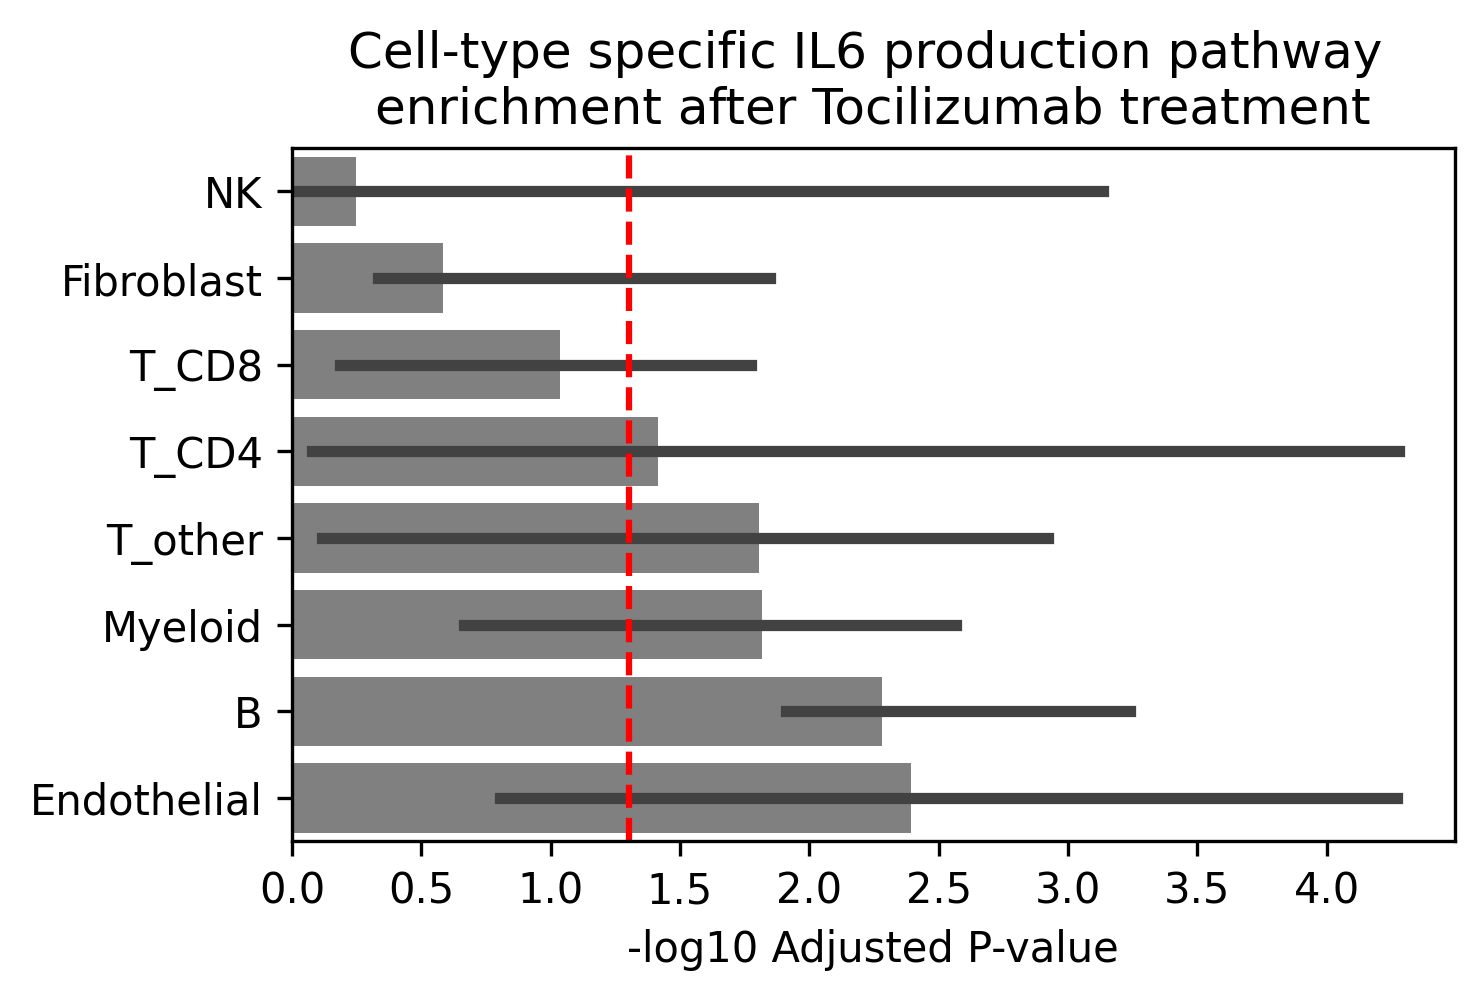

In [65]:
# now combine the enrichments and plot them

curr_term = ["GOBP_NEGATIVE_REGULATION_OF_CYTOKINE_PRODUCTION"]
curr_term = ["GOBP_INTERLEUKIN_6_PRODUCTION"]

def format_df(in_df, curr_term):
    in_df = in_df.iloc[np.where(np.isin(in_df.Term, curr_term))[0]]
    if in_df.iloc[np.where(np.isin(in_df.Term, curr_term))[0]].shape[0] == 0:
        in_df["Term"] = curr_term
        in_df["Adjusted P-value"] = 1
        in_df["Odds Ratio"] = 0

    return in_df
    


def make_plot_df(in_df1, in_df2, in_df3, curr_term, cell_type):
    in_df1 = format_df(in_df1, curr_term)
    in_df2 = format_df(in_df2, curr_term)
    in_df3 = format_df(in_df3, curr_term)

    in_df1["Run ID"] = 1
    in_df2["Run ID"] = 2
    in_df3["Run ID"] = 3

    in_df1["Cell Type"] = cell_type
    in_df2["Cell Type"] = cell_type
    in_df3["Cell Type"] = cell_type


    full_df = pd.concat([in_df1, in_df2, in_df3])

    full_df["Median Odds Ratio"] = np.median(full_df["Odds Ratio"])

    return full_df


Myeloid_prop_df = make_plot_df(Myeloid_toc_enr_res1.res2d, 
                               Myeloid_toc_enr_res2.res2d,
                               Myeloid_toc_enr_res3.res2d,
                               curr_term, "Myeloid")


Fibroblast_prop_df = make_plot_df(Fibroblast_toc_enr_res1.res2d, 
                               Fibroblast_toc_enr_res2.res2d,
                               Fibroblast_toc_enr_res3.res2d,
                               curr_term, "Fibroblast")

Endothelial_prop_df = make_plot_df(Endothelial_toc_enr_res1.res2d, 
                               Endothelial_toc_enr_res2.res2d,
                               Endothelial_toc_enr_res3.res2d,
                               curr_term, "Endothelial")

NK_prop_df = make_plot_df(NK_toc_enr_res1.res2d, 
                               NK_toc_enr_res2.res2d,
                               NK_toc_enr_res3.res2d,
                               curr_term, "NK")


T_CD8_prop_df = make_plot_df(T_CD8_toc_enr_res1.res2d, 
                               T_CD8_toc_enr_res2.res2d,
                               T_CD8_toc_enr_res3.res2d,
                               curr_term, "T_CD8")


T_CD4_prop_df = make_plot_df(T_CD4_toc_enr_res1.res2d, 
                               T_CD4_toc_enr_res2.res2d,
                               T_CD4_toc_enr_res3.res2d,
                               curr_term, "T_CD4")

 
T_other_prop_df = make_plot_df(T_other_toc_enr_res1.res2d, 
                               T_other_toc_enr_res2.res2d,
                               T_other_toc_enr_res3.res2d,
                               curr_term, "T_other")


B_prop_df = make_plot_df(B_toc_enr_res1.res2d, 
                               B_toc_enr_res2.res2d,
                               B_toc_enr_res3.res2d,
                               curr_term, "B")




plot_enr_df = pd.concat([Myeloid_prop_df,
                        Fibroblast_prop_df,
                        Endothelial_prop_df,
                        NK_prop_df,
                        T_CD8_prop_df,
                        T_CD4_prop_df,
                        T_other_prop_df,
                        B_prop_df])


plot_enr_df["-log10 Adjusted P-value"] = -1 * np.log10(plot_enr_df["Adjusted P-value"])

plot_enr_df = plot_enr_df.sort_values(by="Median Odds Ratio")

# plot
fig, axs = plt.subplots(1, 1,  figsize=(5,3), dpi=300)

sns.barplot(data=plot_enr_df, estimator=np.median,
        x="-log10 Adjusted P-value", y="Cell Type",color="grey",
        ax= axs)

axs.set(ylabel=None)

axs.set_title(f"Cell-type specific IL6 production pathway \nenrichment after Tocilizumab treatment")
axs.axvline(x=-1*np.log10(0.05), color="red", linestyle="dashed")

fig.show()


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/4062290796.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_df1["Run ID"] = 1
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/4062290796.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_df2["Run ID"] = 2
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/4062290796.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

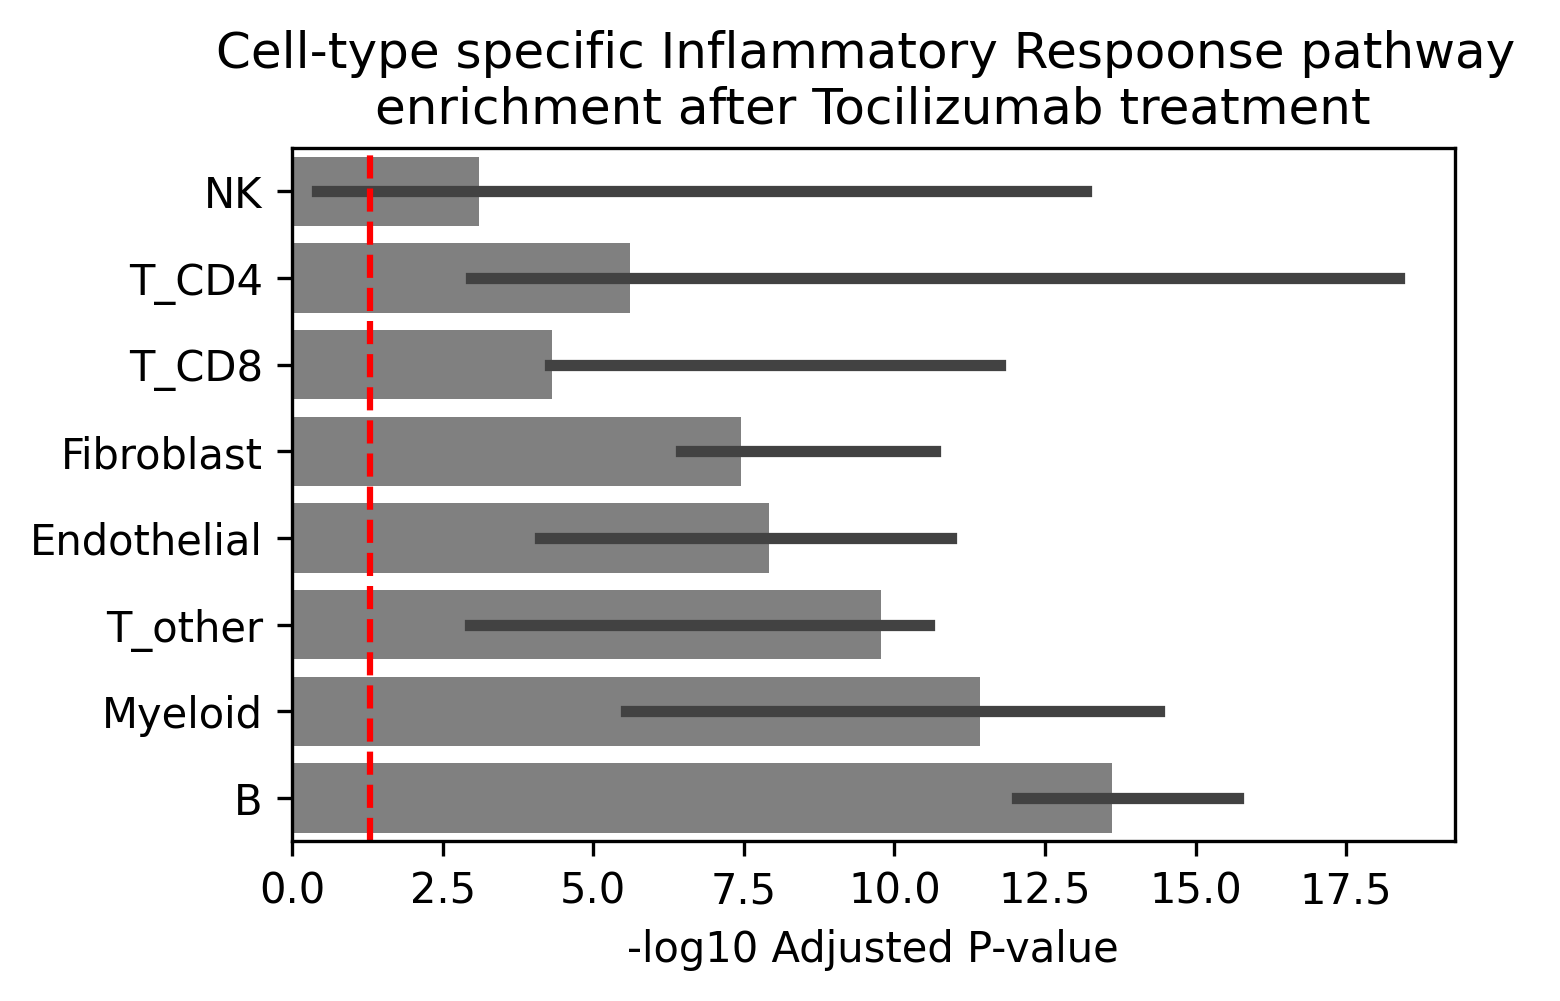

In [66]:
# now combine the enrichments and plot them

curr_term = ["GOBP_INFLAMMATORY_RESPONSE"]

def format_df(in_df, curr_term):
    in_df = in_df.iloc[np.where(np.isin(in_df.Term, curr_term))[0]]
    if in_df.iloc[np.where(np.isin(in_df.Term, curr_term))[0]].shape[0] == 0:
        in_df["Term"] = curr_term
        in_df["Adjusted P-value"] = 1
        in_df["Odds Ratio"] = 0

    return in_df
    


def make_plot_df(in_df1, in_df2, in_df3, curr_term, cell_type):
    in_df1 = format_df(in_df1, curr_term)
    in_df2 = format_df(in_df2, curr_term)
    in_df3 = format_df(in_df3, curr_term)

    in_df1["Run ID"] = 1
    in_df2["Run ID"] = 2
    in_df3["Run ID"] = 3

    in_df1["Cell Type"] = cell_type
    in_df2["Cell Type"] = cell_type
    in_df3["Cell Type"] = cell_type


    full_df = pd.concat([in_df1, in_df2, in_df3])

    full_df["Median Odds Ratio"] = np.median(full_df["Odds Ratio"])

    return full_df


Myeloid_prop_df = make_plot_df(Myeloid_toc_enr_res1.res2d, 
                               Myeloid_toc_enr_res2.res2d,
                               Myeloid_toc_enr_res3.res2d,
                               curr_term, "Myeloid")


Fibroblast_prop_df = make_plot_df(Fibroblast_toc_enr_res1.res2d, 
                               Fibroblast_toc_enr_res2.res2d,
                               Fibroblast_toc_enr_res3.res2d,
                               curr_term, "Fibroblast")

Endothelial_prop_df = make_plot_df(Endothelial_toc_enr_res1.res2d, 
                               Endothelial_toc_enr_res2.res2d,
                               Endothelial_toc_enr_res3.res2d,
                               curr_term, "Endothelial")

NK_prop_df = make_plot_df(NK_toc_enr_res1.res2d, 
                               NK_toc_enr_res2.res2d,
                               NK_toc_enr_res3.res2d,
                               curr_term, "NK")


T_CD8_prop_df = make_plot_df(T_CD8_toc_enr_res1.res2d, 
                               T_CD8_toc_enr_res2.res2d,
                               T_CD8_toc_enr_res3.res2d,
                               curr_term, "T_CD8")


T_CD4_prop_df = make_plot_df(T_CD4_toc_enr_res1.res2d, 
                               T_CD4_toc_enr_res2.res2d,
                               T_CD4_toc_enr_res3.res2d,
                               curr_term, "T_CD4")

 
T_other_prop_df = make_plot_df(T_other_toc_enr_res1.res2d, 
                               T_other_toc_enr_res2.res2d,
                               T_other_toc_enr_res3.res2d,
                               curr_term, "T_other")


B_prop_df = make_plot_df(B_toc_enr_res1.res2d, 
                               B_toc_enr_res2.res2d,
                               B_toc_enr_res3.res2d,
                               curr_term, "B")




plot_enr_df = pd.concat([Myeloid_prop_df,
                        Fibroblast_prop_df,
                        Endothelial_prop_df,
                        NK_prop_df,
                        T_CD8_prop_df,
                        T_CD4_prop_df,
                        T_other_prop_df,
                        B_prop_df])


plot_enr_df["-log10 Adjusted P-value"] = -1 * np.log10(plot_enr_df["Adjusted P-value"])

plot_enr_df = plot_enr_df.sort_values(by="Median Odds Ratio")

# plot
fig, axs = plt.subplots(1, 1,  figsize=(5,3), dpi=300)

sns.barplot(data=plot_enr_df, estimator=np.median,
        x="-log10 Adjusted P-value", y="Cell Type",color="grey",
        ax= axs)

axs.set(ylabel=None)
axs.axvline(x=-1*np.log10(0.05), color="red", linestyle="dashed")

axs.set_title(f"Cell-type specific Inflammatory Respoonse pathway \nenrichment after Tocilizumab treatment")

fig.show()


# Cell type proportions

In [67]:
# now lets compare the b cell proportions before and after
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.samp_type == "bulk"))[0]
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = res1_classifier.predict(X_tmp, batch_size=500)

# compare before and after
temp_meta_df = meta_df.iloc[idx_tmp]


# get b cell proportions
b_index = np.where(Y_full.columns == 'B')[0]
b_prop = prop_outputs[:,b_index]
b_prop = b_prop.flatten()
temp_meta_df.loc[:,"B_cell_prop"] = b_prop


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-02 14:06:20.592873: W tensorflow/c/c_api.cc:304] Operation '{name:'cls_out/Softmax' id:943 op device:{requested: '', assigned: ''} def:{{{node cls_out/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](cls_out/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/1331642558.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/901626645.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcell_pivot["drug"].iloc[np.where(np.isnan(bcell_pivot.rit_diff))[0]] = "Tocilizumab"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/901626645.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcell_pivot["prop_diff"].iloc[np.where(np.isnan(bcell_pivot.rit_diff))[0]] = bcell_pivot.toc_diff.iloc[np.where(np.isnan(bcell_pivot.rit_diff))[0]]
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_1229/901626645.py:35: UserWarning: Matplotlib is currently using module://matplo

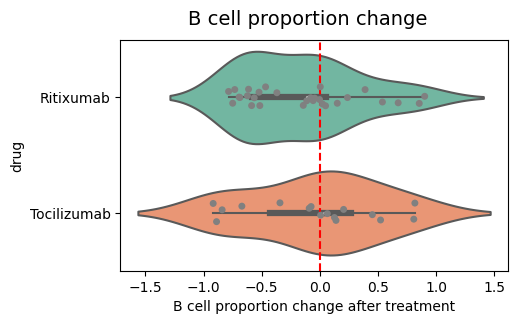

In [68]:
curr_cell = "B cell"
bcell_pivot = temp_meta_df.iloc[np.where(temp_meta_df.paired == "paired")[0]].pivot(index='sample_id', columns='stim', values='B_cell_prop')

bcell_pivot["rit_diff"] = bcell_pivot.rit - bcell_pivot.CTRL
bcell_pivot["toc_diff"] = bcell_pivot.toc - bcell_pivot.CTRL

# add in the drug ID back
bcell_pivot["drug"] = "Ritixumab"
bcell_pivot["drug"].iloc[np.where(np.isnan(bcell_pivot.rit_diff))[0]] = "Tocilizumab"

# combine the prop diff
bcell_pivot["prop_diff"] = bcell_pivot.rit_diff
bcell_pivot["prop_diff"].iloc[np.where(np.isnan(bcell_pivot.rit_diff))[0]] = bcell_pivot.toc_diff.iloc[np.where(np.isnan(bcell_pivot.rit_diff))[0]]
bcell_pivot

fig, axs = plt.subplots(1, 1, figsize=(5,3))

sns.violinplot(data=bcell_pivot, 
            y="drug", x="prop_diff",
            ax= axs)
sns.stripplot(data=bcell_pivot, 
            y="drug", x="prop_diff",
            ax= axs, color="grey")
axs.set(xlabel=f"{curr_cell} proportion change after treatment")
#axs.set_yticklabels(axs.get_yticklabels(), rotation=45, horizontalalignment='right')
axs.axvline(x = 0, color = "red", linestyle = "dashed") 
 
 
 



fig.suptitle(f"{curr_cell} proportion change", fontsize=14)

fig.show()